# Modelling

In this notebook we will take the amazon instrument reviews and predict their sentiment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalAveragePooling1D, Flatten
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier    #deprecated and gave errors
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam

seed = 2
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import random
random.seed(seed)

#some future warnings to ignore when using the KerasClassifier with gridsearch
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_pickle('pre-processed_data.pkl')

df.head()

,helpful,reviewText,summary,reviewRating
0,0.000000,"[much, write, here, ,, exactly, supposed, to, ...",[good],good
1,0.928571,"[product, exactly, quite, affordable.i, realiz...",[jake],good
2,1.000000,"[primary, job, device, block, breath, would, o...","[job, well]",good
3,0.000000,"[nice, windscreen, protects, mxl, mic, prevent...","[good, windscreen, money]",good
4,0.000000,"[pop, filter, great, ., look, performs, like, ...","[pop, record, vocals, .]",good


First we need to split the data into training and testing sets.

In [3]:
#we need to put the strings back together
df['reviewText'] = df['reviewText'].str.join(' ')
df['summary'] = df['summary'].str.join(' ')

In [4]:
#X = df[['reviewText', 'summary']]
#concatenate the two text columns to get our X data
X = df['reviewText'] + ' ' + df['summary']
y = df['reviewRating']

#keeping the sentiments here in case we need them for any data analysis
X_train, X_test, y_train_sent, y_test_sent = train_test_split(X, y, test_size=0.25, random_state=seed)

## Bag of Words

First we will try bag of words, with the Term Frequency-Inverse Document Frequency vectorizer in python. We will use two models, the naive bayes model and a support vector machine, since these two are typically considered to be good for sentiment analysis tasks. 

For the metric, the accuracy and F1 score are usually metrics used in sentiment problems. Because this data is very imblanced though, we will use the weighted F1 score.

Here we will get the data. We have to fit and transform two text features, so we can do them seperately and then concatenate them back into one dataframe, which will be the X data.

In [5]:
tfidf = TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,2))

tfidf_X_train = tfidf.fit_transform(X_train)
tfidf_X_test = tfidf.transform(X_test)

In [6]:
tfidf_X_train

<7695x212105 sparse matrix of type '<class 'numpy.float64'>'
	with 212105 stored elements in Compressed Sparse Row format>

Now let's encode the target variable.

In [7]:
#get the y labels as numbers so we can predict them
le = LabelEncoder()
y_train = le.fit_transform(y_train_sent)
y_test = le.transform(y_test_sent)

Note that here now we have that: 0 is bad, 1 is good, and 2 is neutral.

### Naive Bayes

The multinomial Naive Bayes is typically what is used for text classification, like this problem. We will use that now. Let's try the base model first.

In [8]:
nb = MultinomialNB()

nb_tfidf = nb.fit(tfidf_X_train, y_train)

In [9]:
nb_tfidf_predict = nb.predict(tfidf_X_test)

In [10]:
nb.score(tfidf_X_train, y_train)

0.8796621182586095

In [11]:
nb.score(tfidf_X_test, y_test)

0.882307092751364

In [12]:
confusion_matrix(y_test, nb_tfidf_predict)

array([[   0,  107,    0],
       [   0, 2264,    0],
       [   0,  195,    0]], dtype=int64)

So the basic model predicts only good sentiments. This makes sense since the data is heavily skewed that way. This next function is a function that will plot a scoring metric for a range of a certain parameter value. Essentially mimicing gridsearch for one hyperparameter. There is only one hyperparameter here, so we can just look at that, being alpha.

In [8]:
#function that plots a score against parameter values, to allow us to visualize how a certain parameter affects the score
def plot_train_val_scores(model, param_name, param_range, logplot = False, scoring_metric='f1_macro', y_label='f1 score'):
    #using the validation_curve function to get the score values
    train_scores, valid_scores = validation_curve(model, tfidf_X_train, y_train, 
                                                  param_name=param_name, 
                                                  param_range=param_range, 
                                                  cv=5,
                                                  scoring=scoring_metric, 
                                                  n_jobs=-1)
    
    #take the mean of the cross validation scores and plot these
    train_scores_mean = train_scores.mean(axis=1)
    valid_scores_mean = valid_scores.mean(axis=1)
    
    #if the var_smoothing parameter ranges increase exponentially, we need to take the log of it to get a better visual
    if logplot:
        plt.semilogx(param_range, train_scores_mean, label="Training score")
        plt.semilogx(param_range, valid_scores_mean, label="Validation score")
    else:
        plt.plot(param_range, train_scores_mean, label="Training score")
        plt.plot(param_range, valid_scores_mean, label="Validation score")
    
    plt.title('Training and validation scores for {} parameter values'.format(param_name))
    plt.xlabel('parameter range')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

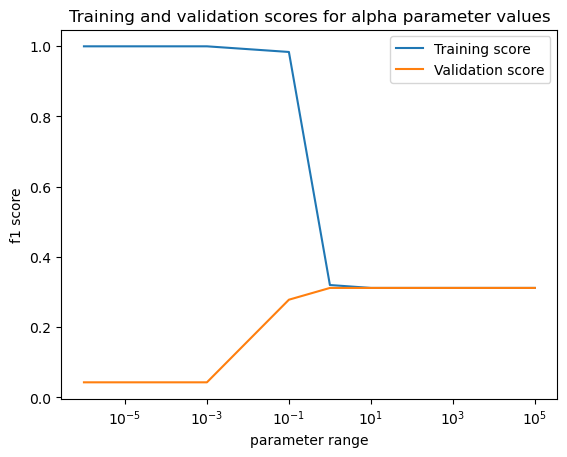

In [70]:
parameter_range = [0.000001, 0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000, 10000, 100000]

plot_train_val_scores(MultinomialNB(), 'alpha', parameter_range, logplot = True)

Not too much happening here. Perhaps taking closer look around the value of 1 will give better ideas on what the optimal alpha value is.

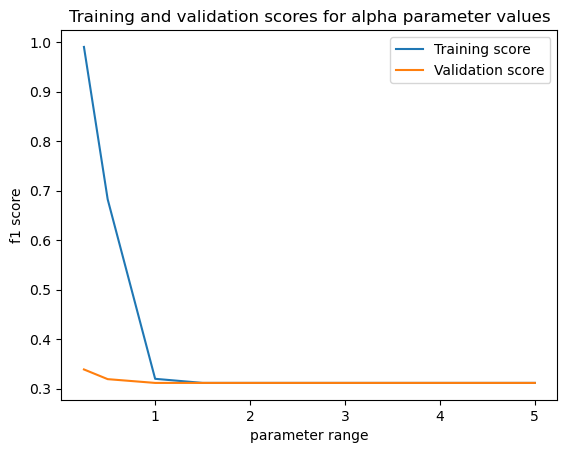

In [71]:
parameter_range = [0.25, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5]

plot_train_val_scores(MultinomialNB(), 'alpha', parameter_range, logplot = False)

Alpha=2 is probably the best here, but anything above it would be fine as well.

In [115]:
nb = MultinomialNB(alpha=2)

nb_tfidf = nb.fit(tfidf_X_train, y_train)

nb_tfidf_predict = nb.predict(tfidf_X_test)

f1_score_nb = f1_score(nb_tfidf_predict, y_test, average = 'macro')
print('Final weighted f1 score for naive bayes model is:', f1_score_nb)

Final weighted f1 score for naive bayes model is: 0.31249137336093863


Now let's look at the confusion matrix. First, we can build a function to avoid repeating the plotting code for the confusion matrix.

In [9]:
def plot_con_mat(y_test, y_pred, title):
    con_mat = confusion_matrix(y_test, y_pred)

    sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
                xticklabels = ["bad", "good", "neutral"], yticklabels = ["bad", "good", "neutral"])
    plt.xlabel('predicted', fontsize=16)
    plt.ylabel('actual', fontsize=16)
    plt.title(title, fontsize=18)
    plt.show()

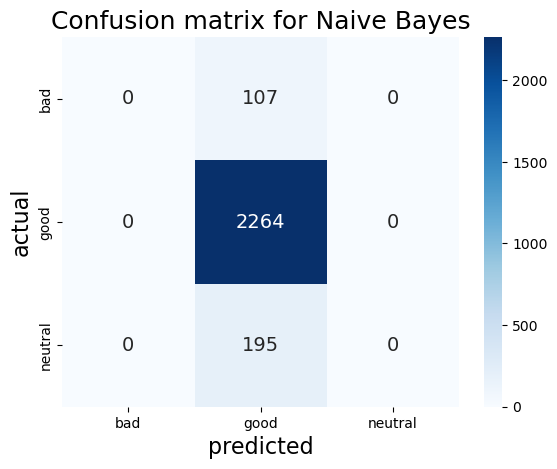

In [116]:
#now let's get the confusion matrix to see how it does
plot_con_mat(y_test, nb_tfidf_predict, 'Confusion matrix for Naive Bayes')

Unfortunately, the best model here still only predicts the good sentiment. Let's try another one.

### Support Vector Machine

A support vector classifier is also used for text classification sometimes, so maybe it will be decent here.

In [29]:
svc = SVC()

In [30]:
svc_tfidf = svc.fit(tfidf_X_train, y_train)

In [31]:
svc_tfidf_predict = svc.predict(tfidf_X_test)

In [32]:
svc.score(tfidf_X_train, y_train)

0.8791423001949318

In [34]:
parameters = {'C': [0.01, 0.1, 1, 10], 
              'degree': [3, 5, 7], 
              'class_weight': [None, 'balanced']
             }

svc = SVC(random_state=seed)

clf = GridSearchCV(svc, parameters, n_jobs=-1, scoring='f1_weighted')

clf.fit(tfidf_X_train, y_train)

GridSearchCV(estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'class_weight': [None, 'balanced'],
                         'degree': [3, 5, 7]},
             scoring='f1_weighted')

In [35]:
clf.best_params_

{'C': 0.01, 'class_weight': None, 'degree': 3}

In [36]:
print('SVC training f1 score after gridsearch is:', clf.score(tfidf_X_train, y_train))
print('SVC testing f1 score after gridsearch is:', clf.score(tfidf_X_test, y_test))

SVC training score after gridsearch is: 0.8225999530869589
SVC testing score after gridsearch is: 0.8232262303792768


Now let's explore the the parameters individually a bit more. Both the C and degree parameters had optimal values less at the bottom range, so we know where to explore next.

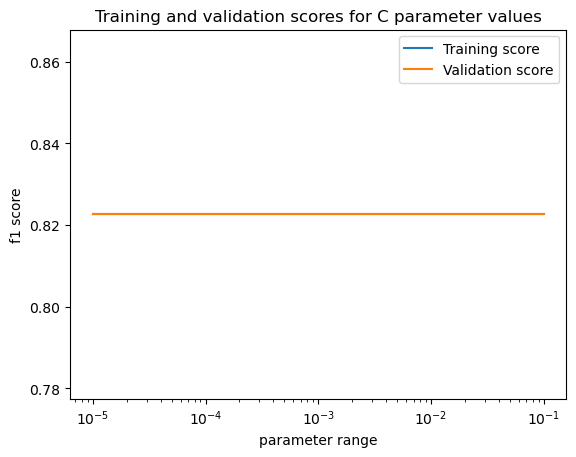

In [33]:
parameter_range = [0.00001, 0.0001, 0.001, 0.1]

plot_train_val_scores(SVC(degree=3, random_state=42), 'C', parameter_range, logplot = True)

It looks like the C value's don't even make a difference. As it turns out, this is because the model is only predicting the dominant sentiment, being good. Thus, until the model can do a better job, these scores will always be what we see here.

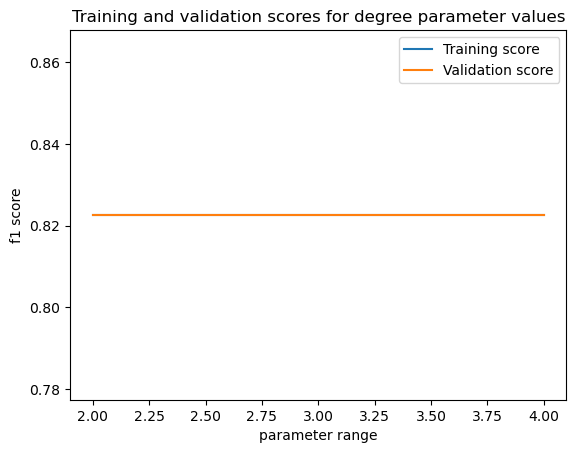

In [38]:
parameter_range = [2, 3, 4]

plot_train_val_scores(SVC(C=0.01, random_state=42), 'degree', parameter_range, logplot = False)

Same issue as before. Let's build the model from gridsearch and show the confusion matrix, to see how this model can't detect the neutral or bad sentiments.

In [97]:
svc = SVC(C=0.01, degree=3, random_state=seed)

svc.fit(tfidf_X_train, y_train)

svc_tfidf_predict = svc.predict(tfidf_X_test)

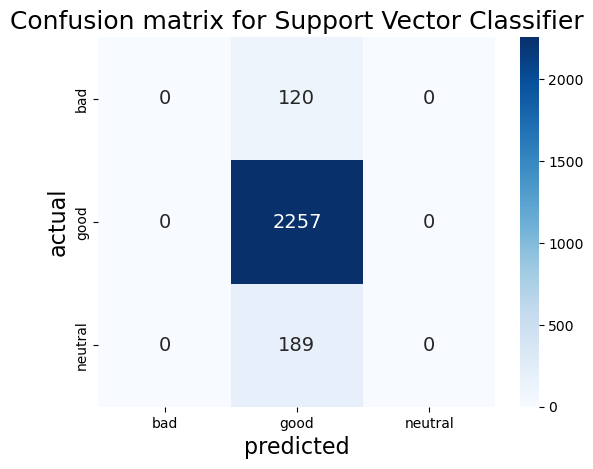

In [98]:
#now let's get the confusion matrix to see how it does
con_mat = confusion_matrix(y_test, svc_tfidf_predict)

sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["bad", "good", "neutral"], yticklabels = ["bad", "good", "neutral"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for Support Vector Classifier', fontsize=18)
plt.show()

### Neural Network

Seems like the models above just are not good enough to handle this unbalanced dataset. Perhaps neural network models can be useful then. First we will try an architecture without LSTM's, and then with. To start off here, we need to do some different pre-processing steps, including tokenizing the text, and then padding them.

In [19]:
# don't want vocab size to be too large
max_vocab = 5000

tokenizer = Tokenizer(max_vocab)

In [20]:
tokenizer.fit_on_texts(X_train)

In [21]:
train_sequence = tokenizer.texts_to_sequences(X_train)
test_sequence = tokenizer.texts_to_sequences(X_test)

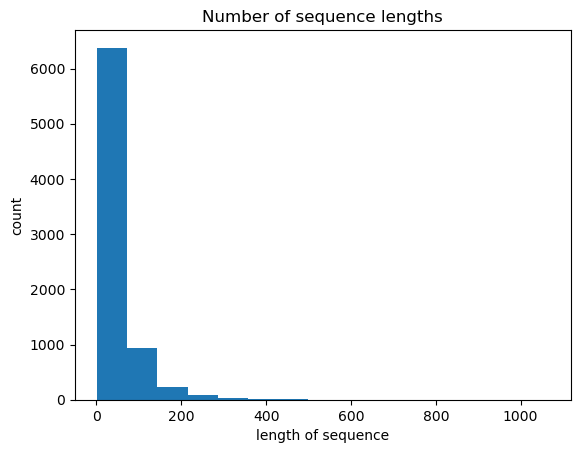

In [22]:
plt.hist([len(seq) for seq in train_sequence], bins = 15)
plt.title('Number of sequence lengths')
plt.ylabel('count')
plt.xlabel('length of sequence')
plt.show()

So this plot tells us most sequences are of length 500 or less. For the padding we can set the max length to 500 then.

In [23]:
padded_train_sequence = pad_sequences(train_sequence, maxlen=500)
padded_test_sequence = pad_sequences(test_sequence, maxlen=500)

padded_train_sequence.shape

(7695, 500)

In [24]:
#we also need to one-hot encode the y data for keras
yy_train = to_categorical(y_train)
yy_test = to_categorical(y_test)

Let's use a sequential model here, starting off with an embedding layer, as is standard for text data. Not super sure what metric is best, so we will look at a few for now. 

In [49]:
#building model, mostly via trail and error
model=Sequential()
model.add(Embedding(max_vocab, 1000, input_length=500))
model.add(GlobalAveragePooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))

#getting the metrics, some from tensorflow add ons
f1_score_macro = tfa.metrics.F1Score(num_classes=3, average='macro', name = 'f1_macro')
f1_score_weighted = tfa.metrics.F1Score(num_classes=3, average='weighted', name = 'f1_weighted')
kappa = tfa.metrics.CohenKappa(num_classes=3, weightage = None, name = 'kappa')
matthew = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=3)

#categorical_crossentropy is for multiclassification, but we need one hot-encoded targets, which we did above
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1_score_macro, f1_score_weighted, kappa, matthew])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 1000)         5000000   
                                                                 
 global_average_pooling1d (G  (None, 1000)             0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                32032     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 5,032,131
Trainable params: 5,032,131
Non-trainable params: 0
______________________________________________

In [32]:
model.fit(padded_train_sequence, 
          yy_train,
          validation_split = 0.25,
          batch_size = 32,
          epochs = 15,
          class_weight = None
         )

Epoch 1/15
181/181 [==============================] - 5s 19ms/step - loss: 0.5093 - accuracy: 0.8730 - f1_macro: 0.3146 - f1_weighted: 0.8192 - kappa: -0.0022 - MatthewsCorrelationCoefficient: -0.0055 - val_loss: 0.4439 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/15
181/181 [==============================] - 3s 15ms/step - loss: 0.4628 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4378 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/15
181/181 [==============================] - 3s 14ms/step - loss: 0.4428 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4240 - val_accuracy: 0.8789 - val_f1_macro:

In [10]:
def plot_metric_history(metrics, suptitle = 'Evaluation metrics'):
    fig, axes = plt.subplots(2, 2, figsize=(12,8))

    #axes[0, 0].plot(metrics['accuracy'])
    #axes[0, 0].plot(metrics['val_accuracy'])
    #axes[0, 0].set_title('accuracy')

    axes[0, 0].plot(metrics['f1_macro'])
    axes[0, 0].plot(metrics['val_f1_macro'])
    axes[0, 0].set_title('f1_macro')

    axes[0, 1].plot(metrics['f1_weighted'])
    axes[0, 1].plot(metrics['val_f1_weighted'])
    axes[0, 1].set_title('f1_weighted')

    axes[1, 0].plot(metrics['kappa'])
    axes[1, 0].plot(metrics['val_kappa'])
    axes[1, 0].set_title('cohen_kappa')

    axes[1, 1].plot(metrics['MatthewsCorrelationCoefficient'])
    axes[1, 1].plot(metrics['val_MatthewsCorrelationCoefficient'])
    axes[1, 1].set_title('Matthews Correlation Coefficient')
    
    plt.suptitle(suptitle)

    plt.show()

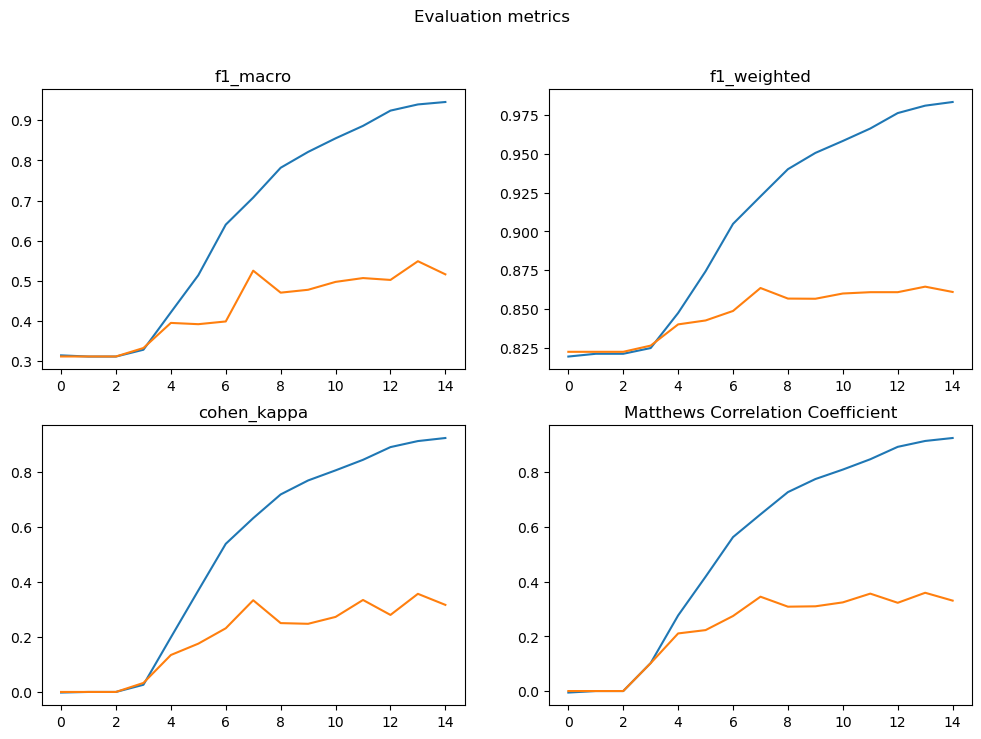

In [33]:
metrics = pd.DataFrame(model.history.history)

plot_metric_history(metrics)

In [11]:
#we will do this step a lot, so makinga  function to save a few lines of code
def get_test_predictions(X_test, NN_model):
    y_pred = NN_model.predict(X_test)

    #the model predicts probablilites, so we need to turn them into classes by taking the largest probability
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

In [34]:
y_pred_classes = get_test_predictions(padded_test_sequence, NN_model = model)

#check to see if the model is at least predicting not just one sentiment
Counter(y_pred_classes)

81/81 [==============================] - 0s 2ms/step


Counter({1: 2378, 2: 111, 0: 77})

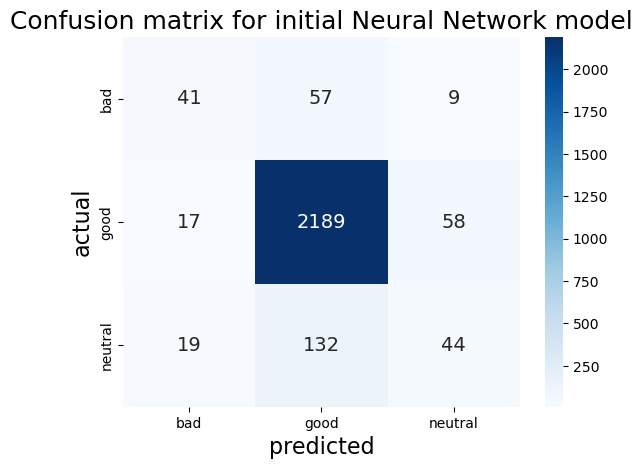

              precision    recall  f1-score   support

           0       0.53      0.38      0.45       107
           1       0.92      0.97      0.94      2264
           2       0.40      0.23      0.29       195

    accuracy                           0.89      2566
   macro avg       0.62      0.53      0.56      2566
weighted avg       0.86      0.89      0.87      2566



In [35]:
plot_con_mat(y_test, y_pred_classes, 'Confusion matrix for initial Neural Network model')

print(classification_report(y_test, y_pred_classes))

Seems like the f1 score is stabilizing after epoch 5 for the test set, while the training set f1 score continues to rise. From this, stopping at epoch 5 or 6 would probably be best. Although, from some initial testing something odd seems to be happening, where after 5 or so epochs the F1 score will stabilize, but the confusion matrices will look different after each epoch, and start worse around 5 epochs (not predict one of the classes very much), then get better, and then worse again. At least that is what is seems like. Let's look at this more closely.

In [24]:
#here is our model as a function
def buildmodel(learning_rate = 0.001, dropout = 0.3):
    model = Sequential([
        Embedding(max_vocab, 1000, input_length=500),
        GlobalAveragePooling1D(),
        Dense(32, activation='relu'),
        Dropout(dropout),
        Dense(3,activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate = learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1_score_macro, f1_score_weighted, kappa, matthew])
    
    return model

In [25]:
def build_model_con_mat(epoch = 6, batch_size = 32, learning_rate = 0.001, plot_metrics = False):
    model = buildmodel(learning_rate = learning_rate)

    model.fit(padded_train_sequence, 
              yy_train,
              validation_split = 0.25,
              batch_size = batch_size,
              epochs = epoch)
    
    metrics = pd.DataFrame(model.history.history)
    
    y_pred = get_test_predictions(padded_test_sequence)

    plot_con_mat(y_test, y_pred, 'Confusion matrix for model with {} epochs, batch_size = {}, and learning_rate = {}'.format(epoch, batch_size, learning_rate))
    
    if plot_metrics:
        #plot the metrics
        plot_metric_history(
            metrics, 
            suptitle = 'Metrics for model with {} epochs, batch_size = {}, and learning_rate = {}'.format(epoch, batch_size, learning_rate))
    

Epoch 1/4
181/181 [==============================] - 4s 18ms/step - loss: 0.5139 - accuracy: 0.8730 - f1_macro: 0.3107 - f1_weighted: 0.8175 - kappa: -0.0036 - MatthewsCorrelationCoefficient: -0.0101 - val_loss: 0.4436 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/4
181/181 [==============================] - 3s 15ms/step - loss: 0.4612 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4382 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/4
181/181 [==============================] - 3s 15ms/step - loss: 0.4493 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4264 - val_accuracy: 0.8789 - val_f1_macro: 0.

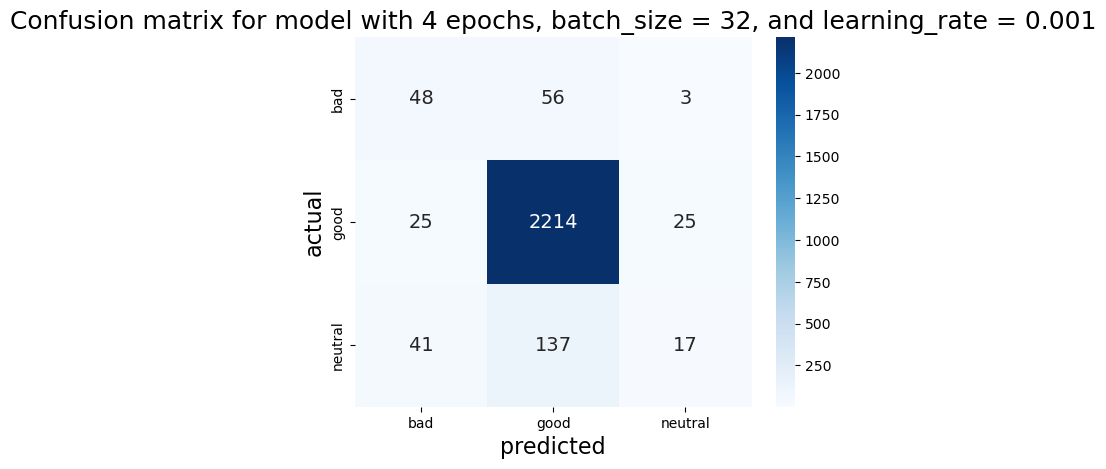

Epoch 1/6
181/181 [==============================] - 4s 18ms/step - loss: 0.5188 - accuracy: 0.8735 - f1_macro: 0.3166 - f1_weighted: 0.8206 - kappa: 0.0020 - MatthewsCorrelationCoefficient: 0.0058 - val_loss: 0.4446 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/6
181/181 [==============================] - 3s 15ms/step - loss: 0.4657 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4384 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/6
181/181 [==============================] - 3s 15ms/step - loss: 0.4508 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4192 - val_accuracy: 0.8789 - val_f1_macro: 0.31

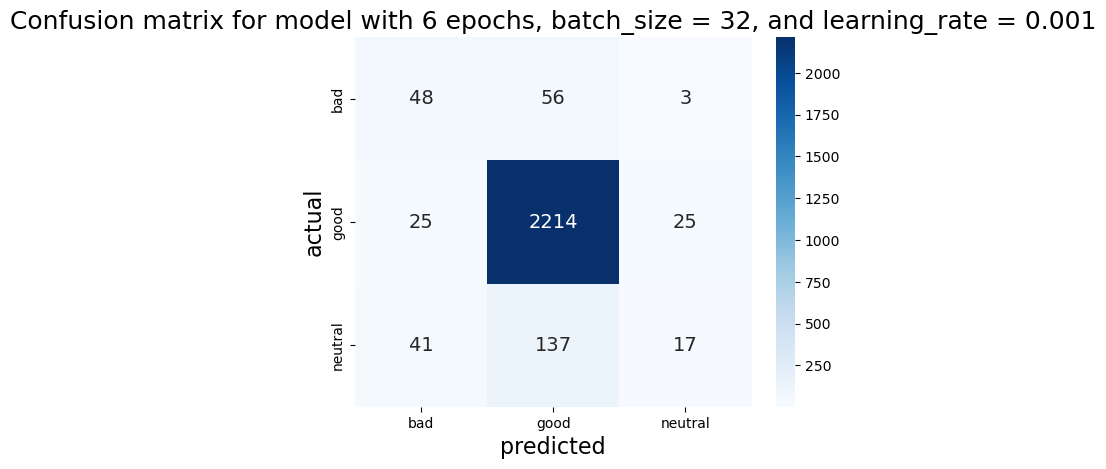

Epoch 1/8
181/181 [==============================] - 4s 18ms/step - loss: 0.5095 - accuracy: 0.8716 - f1_macro: 0.3540 - f1_weighted: 0.8275 - kappa: 0.0612 - MatthewsCorrelationCoefficient: 0.1015 - val_loss: 0.4437 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/8
181/181 [==============================] - 3s 15ms/step - loss: 0.4645 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4388 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/8
181/181 [==============================] - 3s 14ms/step - loss: 0.4473 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4260 - val_accuracy: 0.8789 - val_f1_macro: 0.31

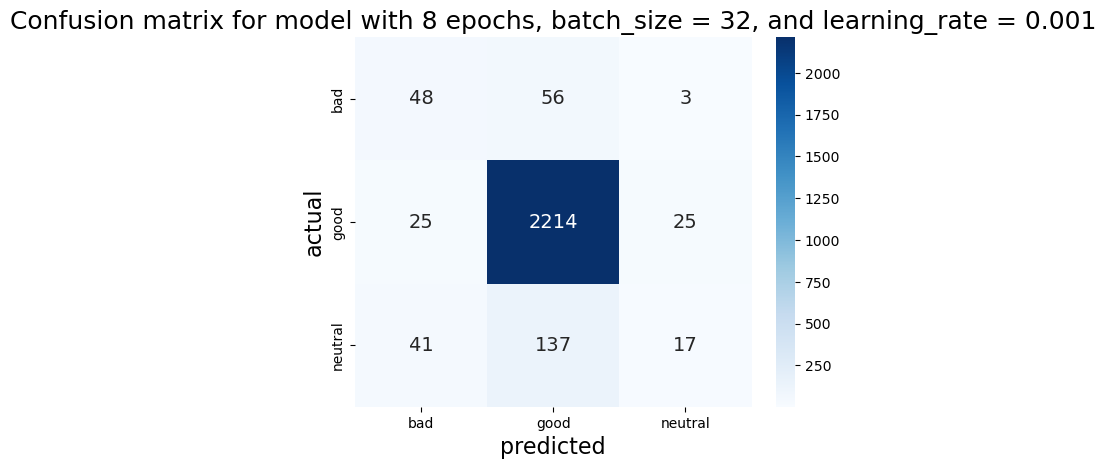

Epoch 1/10
181/181 [==============================] - 4s 19ms/step - loss: 0.5352 - accuracy: 0.8768 - f1_macro: 0.3844 - f1_weighted: 0.8340 - kappa: 0.1083 - MatthewsCorrelationCoefficient: 0.1659 - val_loss: 0.4452 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/10
181/181 [==============================] - 3s 15ms/step - loss: 0.4758 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4403 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/10
181/181 [==============================] - 3s 16ms/step - loss: 0.4622 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4328 - val_accuracy: 0.8789 - val_f1_macro: 0

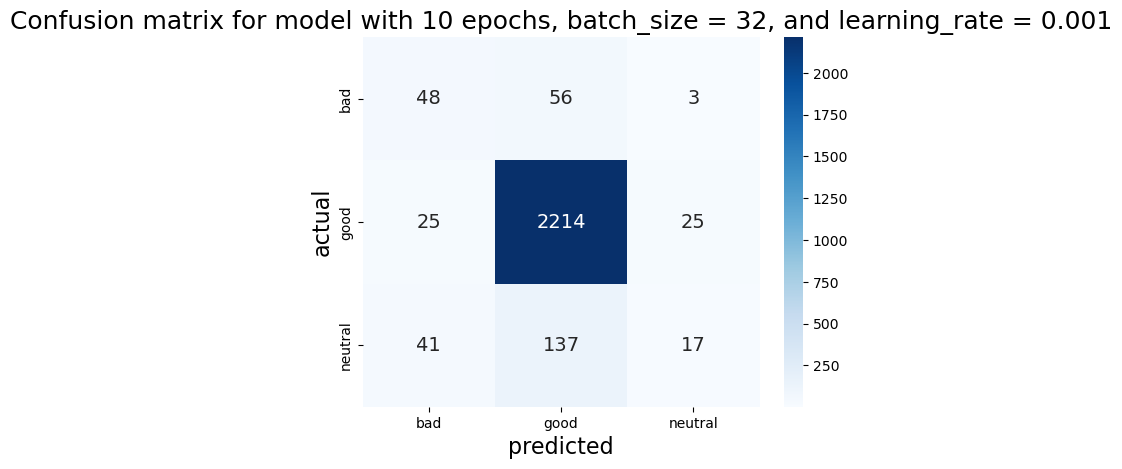

Epoch 1/12
181/181 [==============================] - 4s 19ms/step - loss: 0.5249 - accuracy: 0.8759 - f1_macro: 0.3722 - f1_weighted: 0.8321 - kappa: 0.0813 - MatthewsCorrelationCoefficient: 0.1505 - val_loss: 0.4437 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/12
181/181 [==============================] - 3s 15ms/step - loss: 0.4631 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4384 - val_accuracy: 0.8789 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8222 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/12
181/181 [==============================] - 3s 15ms/step - loss: 0.4483 - accuracy: 0.8780 - f1_macro: 0.3117 - f1_weighted: 0.8210 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4307 - val_accuracy: 0.8789 - val_f1_macro: 0

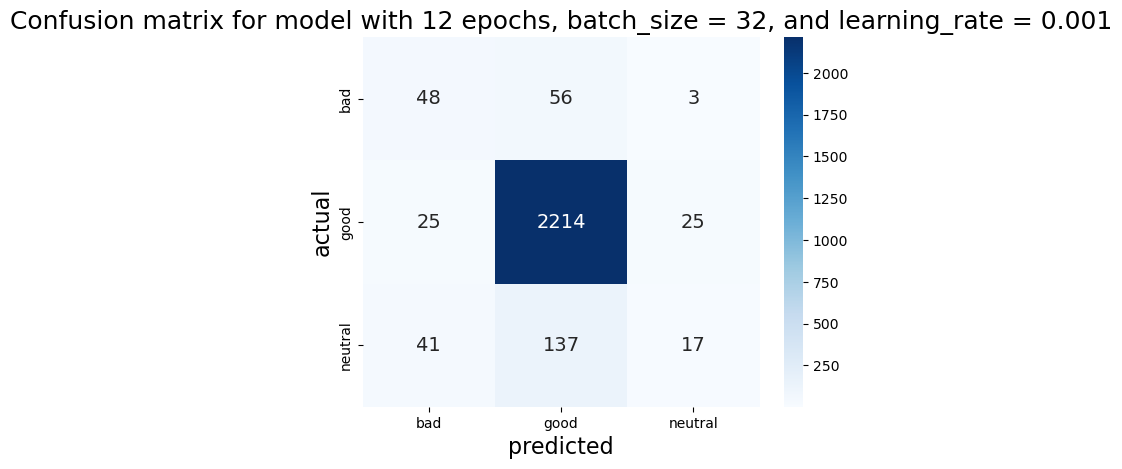

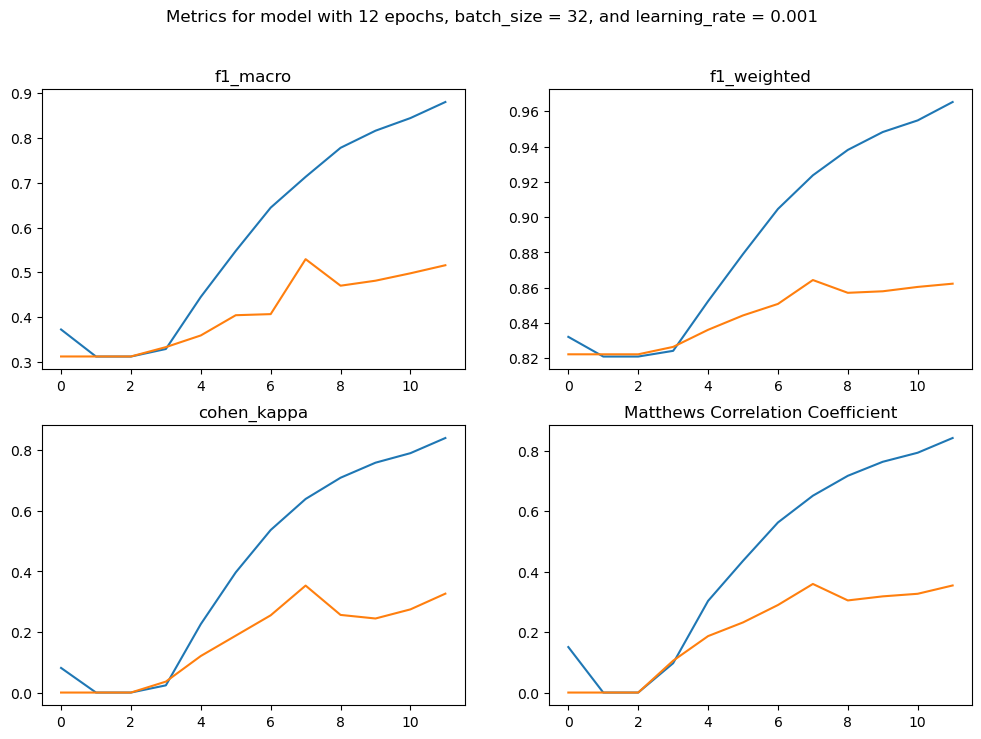

In [176]:
epoch_range = list(range(4, 14, 2))

for e in epoch_range:
    #don't want to print the metric plots for every iteration, to keep things readable
    if e == epoch_range[-1]:
        plot_metrics = True
    else:
        plot_metrics = False
    build_model_con_mat(epoch = e, plot_metrics = plot_metrics)

So the confusion matrix doesn't predict the bad sentiment too well with less epochs. It gets better with more, but starts to get worse again with mroe epochs, all while the evaluation metrics remain stabilized. Even with the simplist model (and dropout layers), overfitting remains a big issue, so let's try adding more data. Specifically, we can up scale the data so that it is more balanced.

Upscaling methods were burrowed from here: https://www.kaggle.com/code/sanjay11100/lstm-sentiment-analysis-data-imbalance-keras. Here, since we are focusing on tuning the model as well, we will split the training data into it's own training and validation data.

In [25]:
#putting the training data back together to filter for each sentiment
mod_df = pd.concat([X_train, y_train_sent], axis=1)
mod_df.rename({0: 'text'}, axis=1, inplace = True)

mod_df.head()

,text,reviewRating
357,one awesome guitar ! also purchased fender mus...,good
9031,dont often use pick soprano uke . mahalo pick ...,good
8893,"one best , simple use , guitar tuner ive used ...",good
2529,absolutely obligatory fan rock n roll jamming ...,neutral
8332,tuner work great . vibration mic.only real pro...,bad


In [26]:
#seperating the sentiments.
good_df = mod_df[mod_df['reviewRating'] == 'good']
neutral_df = mod_df[mod_df['reviewRating'] == 'neutral']
bad_df = mod_df[mod_df['reviewRating'] == 'bad']

In [27]:
#geting the new training sets, per sentiment - same ratio for each
train_good = good_df.sample(frac=0.75, random_state=seed)
train_neutral = neutral_df.sample(frac=0.75, random_state=seed)
train_bad = bad_df.sample(frac=0.75, random_state=seed)

#putting them together to get our new training dataframe
train_df = pd.concat([train_good, train_neutral, train_bad])

#this drops the training data from the df's above, 
#so the 25% that isn't in the training dataframe will be our validation data
val_df = pd.concat([good_df.drop(train_good.index), neutral_df.drop(train_neutral.index), bad_df.drop(train_bad.index)])

In [28]:
# Upsample minority classes
train_neutral_upsampled = resample(train_neutral, 
                                 replace=True,     # sample with replacement
                                 n_samples= train_good.shape[0], # to match majority class which is the good sentiment
                                 random_state=seed) # reproducible results

train_bad_upsampled = resample(train_bad, 
                                 replace=True,     # sample with replacement
                                 n_samples= train_good.shape[0], # to match majority class which is the good sentiment
                                 random_state=seed) # reproducible results

#down sample to match the bad sentiment, which has the least samples
train_good_downsampled = resample(train_good, 
                                 replace=True,     # sample with replacement
                                 n_samples= train_bad.shape[0], # to match majority class which is the good sentiment
                                 random_state=seed) # reproducible results

train_neutral_downsampled = resample(train_neutral, 
                                 replace=True,     # sample with replacement
                                 n_samples= train_bad.shape[0], # to match majority class which is the good sentiment
                                 random_state=seed) # reproducible results

In [29]:
#now putting the training dataframes together for the upsampled and downsampled versions each
train_df_upsampled = pd.concat([train_good, train_neutral_upsampled, train_bad_upsampled])
print(train_df_upsampled.shape)

train_df_downsampled = pd.concat([train_bad, train_neutral_downsampled, train_good_downsampled])
print(train_df_downsampled.shape)

(15204, 2)
(810, 2)


In [30]:
#can do this step again, but unnecessary if ran it above
#tokenizer = Tokenizer(max_vocab)
#tokenizer.fit_on_texts(X_train)

Now we must pre-process the training data again, for all the different versions.

In [31]:
#split the normal training data into x and y, just for comparison
X_train_not_upsampled = train_df['text']
y_train_not_upsampled = train_df['reviewRating']

#split the training upsampled data into x and y
X_train_upsampled = train_df_upsampled['text']
y_train_upsampled = train_df_upsampled['reviewRating']

#split the training downsampled data into x and y
X_train_downsampled = train_df_downsampled['text']
y_train_downsampled = train_df_downsampled['reviewRating']

#split the validation data into x and y
X_val = val_df['text']
y_val = val_df['reviewRating']

#tokenize the text
train_sequence_not_upsampled = tokenizer.texts_to_sequences(X_train_not_upsampled)
train_sequence_upsampled = tokenizer.texts_to_sequences(X_train_upsampled)
train_sequence_downsampled = tokenizer.texts_to_sequences(X_train_downsampled)
val_sequence_upsampled = tokenizer.texts_to_sequences(X_val)

#pad the text sequences
padded_train_sequence_not_upsampled = pad_sequences(train_sequence_not_upsampled, maxlen=500)
padded_train_sequence_upsampled = pad_sequences(train_sequence_upsampled, maxlen=500)
padded_train_sequence_downsampled = pad_sequences(train_sequence_downsampled, maxlen=500)
padded_val_sequence = pad_sequences(val_sequence_upsampled, maxlen=500)

#change the y labels into numbers
y_train_not_upsampled_labels = le.transform(y_train_not_upsampled)
y_train_upsampled_labels = le.transform(y_train_upsampled)
y_train_downsampled_labels = le.transform(y_train_downsampled)
y_val_labels = le.transform(y_val)

#now turn these number labels into one-hot encoded format for keras like before
yy_train_not_upsampled = to_categorical(y_train_not_upsampled_labels)
yy_train_upsampled = to_categorical(y_train_upsampled_labels)
yy_train_downsampled = to_categorical(y_train_downsampled_labels)
yy_val = to_categorical(y_val_labels)

Something else we can test is adding class weights. which we can get from a python package is sklearn. We might not use it just yet, but it is here now just in case.

In [32]:
class_weights = compute_class_weight(class_weight = 'balanced', 
                                     classes = np.unique(y_train_not_upsampled_labels), 
                                     y=y_train_not_upsampled_labels)

class_weights = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}

print(class_weights)

{0: 7.124691358024691, 1: 0.3795711654827677, 2: 4.442648190916089}


Now we can see how well the upsampled or downsampled training sets do. We should start with the non-up or down sampled data first, so have have something to compare it to.

**Regular training data:**

In [52]:
#let's redo this function but include the extra plotting steps so we don't have to repeat it
def buildmodel(X_train, y_train, 
               validation_data = (padded_val_sequence, yy_val), 
               true_y_train_labels = y_train_not_upsampled_labels,
               true_y_test_labels = y_val_labels, 
               print_f1_scores = False, 
               epochs = 10, 
               batch_size = 32, 
               learning_rate = 0.001, 
               dropout = 0.3, 
               metrics_title = 'Evaluation metrics', 
               con_mat_title = 'Confusion matrix', 
               class_weight = None):
    model = Sequential([
        Embedding(max_vocab, 1000, input_length=500),
        GlobalAveragePooling1D(),
        Dense(32, activation='relu'),
        Dropout(dropout),
        Dense(3,activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate = learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1_score_macro, f1_score_weighted, kappa, matthew])

    model.fit(X_train, 
              y_train,
              validation_data = validation_data,
              batch_size = batch_size,
              epochs = epochs, 
              verbose = 1, 
              class_weight = class_weight)
    
    metrics = pd.DataFrame(model.history.history)

    plot_metric_history(metrics, suptitle = metrics_title)
    
    y_pred_probs = model.predict(validation_data[0])
    y_pred = np.argmax(y_pred_probs, axis=1)

    plot_con_mat(true_y_test_labels, y_pred, con_mat_title)

    print(classification_report(true_y_test_labels, y_pred))
    
    if print_f1_scores:
        #predict the y values on the training data
        y_train_pred_probs = model.predict(X_train)
        y_train_pred = np.argmax(y_train_pred_probs, axis=1)
        f1_train_score = f1_score(y_train_pred, true_y_train_labels, average = 'macro')
        f1_test_score = f1_score(y_pred, true_y_test_labels, average = 'macro')
        
        print('f1 training score is:', f1_train_score)
        print('f1 testing score is:', f1_test_score)

Epoch 1/10
181/181 [==============================] - 4s 19ms/step - loss: 0.5022 - accuracy: 0.8782 - f1_macro: 0.3988 - f1_weighted: 0.8368 - kappa: 0.1226 - MatthewsCorrelationCoefficient: 0.1730 - val_loss: 0.4483 - val_accuracy: 0.8784 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8215 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/10
181/181 [==============================] - 3s 16ms/step - loss: 0.4620 - accuracy: 0.8782 - f1_macro: 0.3117 - f1_weighted: 0.8212 - kappa: -1.1921e-07 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4424 - val_accuracy: 0.8784 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8215 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/10
181/181 [==============================] - 3s 16ms/step - loss: 0.4459 - accuracy: 0.8782 - f1_macro: 0.3117 - f1_weighted: 0.8212 - kappa: -1.1921e-07 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4282 - val_accuracy: 0.8784 - val_f1_macro:

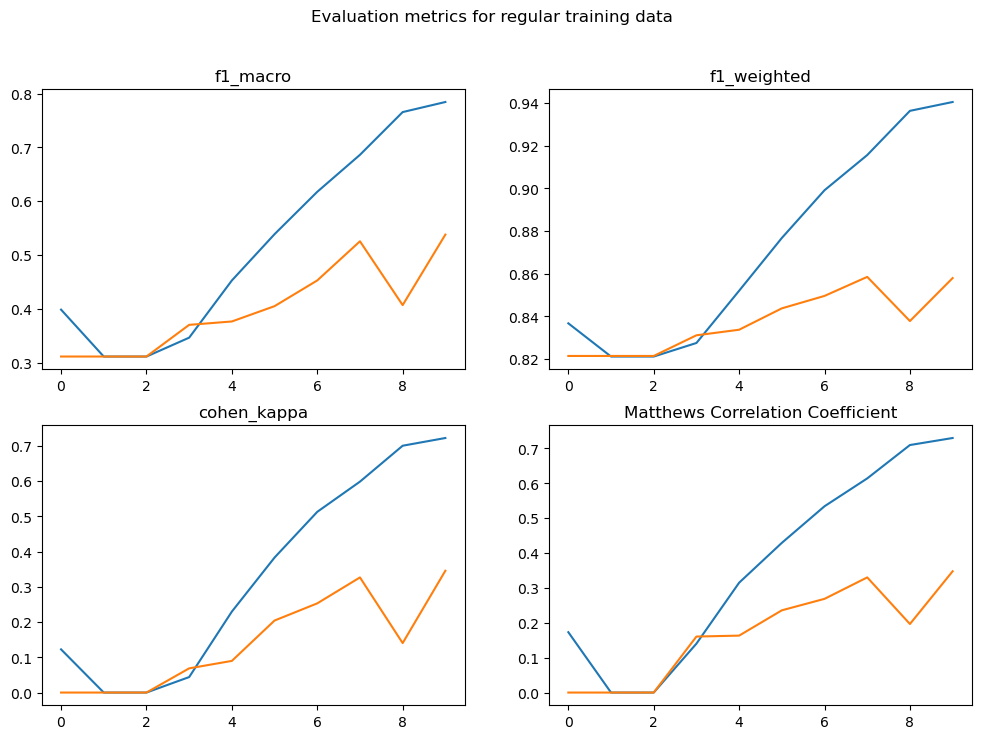

61/61 [==============================] - 0s 2ms/step


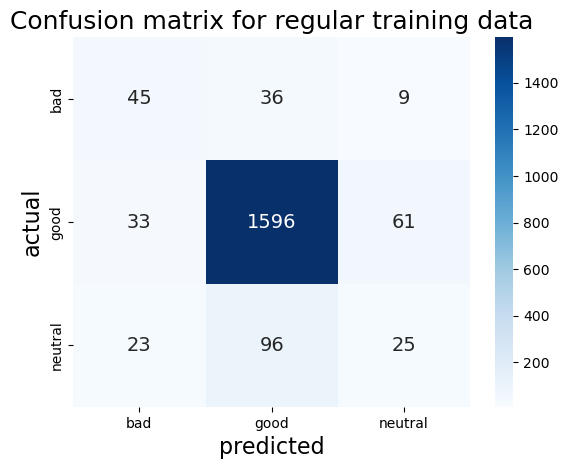

              precision    recall  f1-score   support

           0       0.45      0.50      0.47        90
           1       0.92      0.94      0.93      1690
           2       0.26      0.17      0.21       144

    accuracy                           0.87      1924
   macro avg       0.54      0.54      0.54      1924
weighted avg       0.85      0.87      0.86      1924



In [99]:
buildmodel(padded_train_sequence_not_upsampled, yy_train_not_upsampled, 
           metrics_title = 'Evaluation metrics for regular training data', 
           con_mat_title = 'Confusion matrix for regular training data')

**Downsampled training data:**

Epoch 1/10
26/26 [==============================] - 2s 51ms/step - loss: 1.0998 - accuracy: 0.3395 - f1_macro: 0.4452 - f1_weighted: 0.6752 - kappa: 0.2405 - MatthewsCorrelationCoefficient: 0.2525 - val_loss: 1.0735 - val_accuracy: 0.8643 - val_f1_macro: 0.3239 - val_f1_weighted: 0.8181 - val_kappa: 0.0104 - val_MatthewsCorrelationCoefficient: 0.0156
Epoch 2/10
26/26 [==============================] - 1s 31ms/step - loss: 1.0986 - accuracy: 0.3432 - f1_macro: 0.2494 - f1_weighted: 0.2494 - kappa: 0.0148 - MatthewsCorrelationCoefficient: 0.0244 - val_loss: 1.1067 - val_accuracy: 0.0468 - val_f1_macro: 0.0298 - val_f1_weighted: 0.0042 - val_kappa: -1.5378e-05 - val_MatthewsCorrelationCoefficient: -9.6343e-04
Epoch 3/10
26/26 [==============================] - 1s 31ms/step - loss: 1.1013 - accuracy: 0.3333 - f1_macro: 0.2799 - f1_weighted: 0.2799 - kappa: 5.9605e-08 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 1.0793 - val_accuracy: 0.8529 - val_f1_macro: 0.3251 - val_f1_weigh

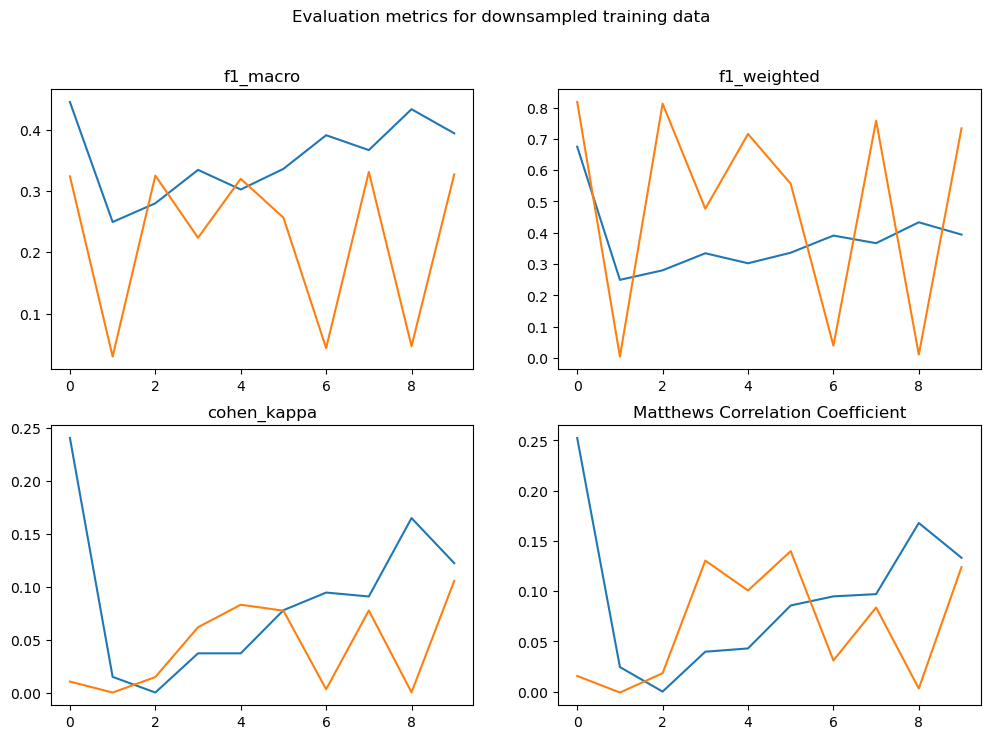

61/61 [==============================] - 0s 2ms/step


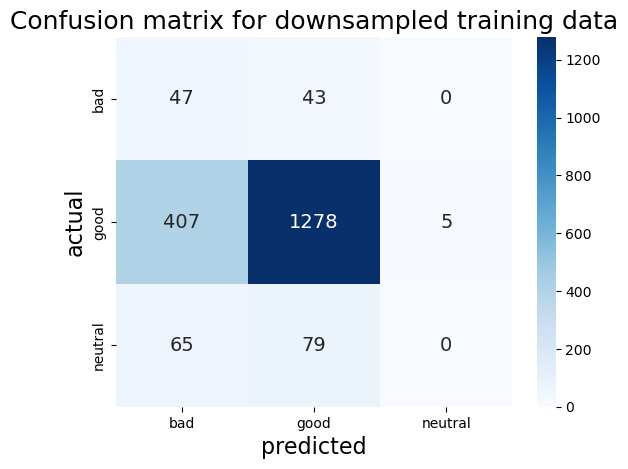

              precision    recall  f1-score   support

           0       0.09      0.52      0.15        90
           1       0.91      0.76      0.83      1690
           2       0.00      0.00      0.00       144

    accuracy                           0.69      1924
   macro avg       0.33      0.43      0.33      1924
weighted avg       0.81      0.69      0.73      1924



In [100]:
buildmodel(padded_train_sequence_downsampled, yy_train_downsampled, 
           metrics_title = 'Evaluation metrics for downsampled training data', 
           con_mat_title = 'Confusion matrix for downsampled training data')

**Upsampled training data:**

Epoch 1/10
476/476 [==============================] - 8s 15ms/step - loss: 1.0367 - accuracy: 0.4291 - f1_macro: 0.4473 - f1_weighted: 0.4589 - kappa: 0.2023 - MatthewsCorrelationCoefficient: 0.2074 - val_loss: 0.7499 - val_accuracy: 0.7698 - val_f1_macro: 0.4967 - val_f1_weighted: 0.8067 - val_kappa: 0.2808 - val_MatthewsCorrelationCoefficient: 0.3102
Epoch 2/10
476/476 [==============================] - 6s 13ms/step - loss: 0.4140 - accuracy: 0.8492 - f1_macro: 0.8482 - f1_weighted: 0.8482 - kappa: 0.7738 - MatthewsCorrelationCoefficient: 0.7743 - val_loss: 0.7158 - val_accuracy: 0.6965 - val_f1_macro: 0.4455 - val_f1_weighted: 0.7571 - val_kappa: 0.2091 - val_MatthewsCorrelationCoefficient: 0.2534
Epoch 3/10
476/476 [==============================] - 6s 14ms/step - loss: 0.1573 - accuracy: 0.9559 - f1_macro: 0.9558 - f1_weighted: 0.9558 - kappa: 0.9338 - MatthewsCorrelationCoefficient: 0.9339 - val_loss: 0.5766 - val_accuracy: 0.8321 - val_f1_macro: 0.4997 - val_f1_weighted: 0.8401 

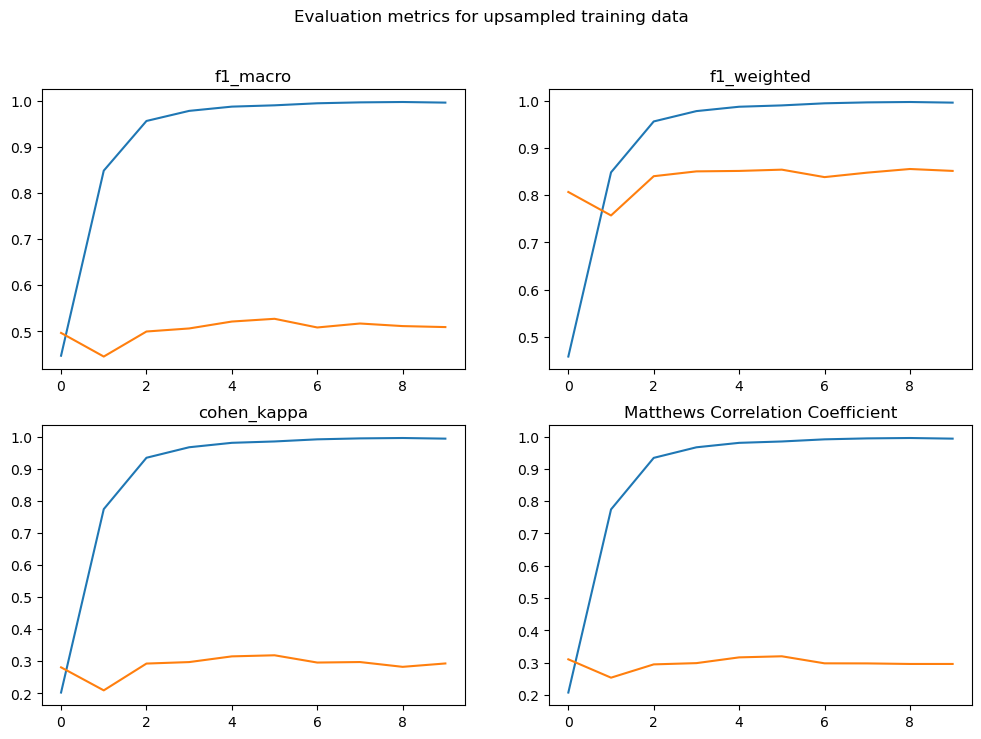

61/61 [==============================] - 0s 2ms/step


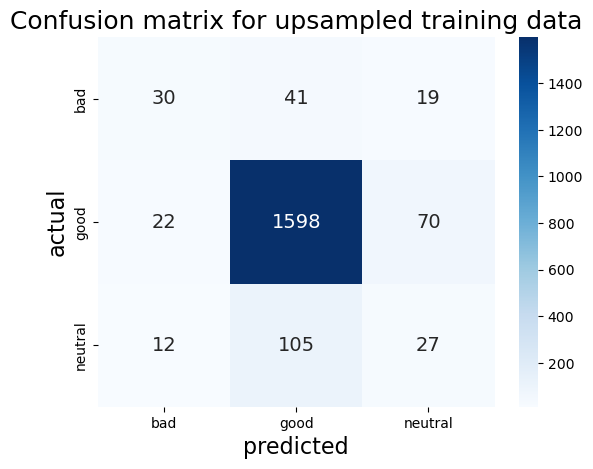

              precision    recall  f1-score   support

           0       0.47      0.33      0.39        90
           1       0.92      0.95      0.93      1690
           2       0.23      0.19      0.21       144

    accuracy                           0.86      1924
   macro avg       0.54      0.49      0.51      1924
weighted avg       0.84      0.86      0.85      1924



In [104]:
buildmodel(padded_train_sequence_upsampled, yy_train_upsampled, 
           metrics_title = 'Evaluation metrics for upsampled training data', 
           con_mat_title = 'Confusion matrix for upsampled training data')

There is one more thing we can try before moving on. That is the SMOTE technique. This is another oversampling technique, where SMOTE uses k neigherest neighbours to add samples to the miniority classes.

In [107]:
sm = SMOTE(random_state = seed)

X_train_sm, y_train_sm = sm.fit_resample(padded_train_sequence_not_upsampled, yy_train_not_upsampled)

Epoch 1/10
476/476 [==============================] - 8s 15ms/step - loss: 1.0976 - accuracy: 0.3467 - f1_macro: 0.3746 - f1_weighted: 0.3883 - kappa: 0.0853 - MatthewsCorrelationCoefficient: 0.0873 - val_loss: 1.0482 - val_accuracy: 0.8228 - val_f1_macro: 0.3318 - val_f1_weighted: 0.8004 - val_kappa: 0.0113 - val_MatthewsCorrelationCoefficient: 0.0118
Epoch 2/10
476/476 [==============================] - 6s 14ms/step - loss: 1.0904 - accuracy: 0.3590 - f1_macro: 0.3476 - f1_weighted: 0.3476 - kappa: 0.0385 - MatthewsCorrelationCoefficient: 0.0396 - val_loss: 1.1439 - val_accuracy: 0.4792 - val_f1_macro: 0.2717 - val_f1_weighted: 0.5717 - val_kappa: 0.0677 - val_MatthewsCorrelationCoefficient: 0.1137
Epoch 3/10
476/476 [==============================] - 6s 13ms/step - loss: 1.0636 - accuracy: 0.4085 - f1_macro: 0.3903 - f1_weighted: 0.3903 - kappa: 0.1128 - MatthewsCorrelationCoefficient: 0.1172 - val_loss: 0.8716 - val_accuracy: 0.8196 - val_f1_macro: 0.3730 - val_f1_weighted: 0.8076 

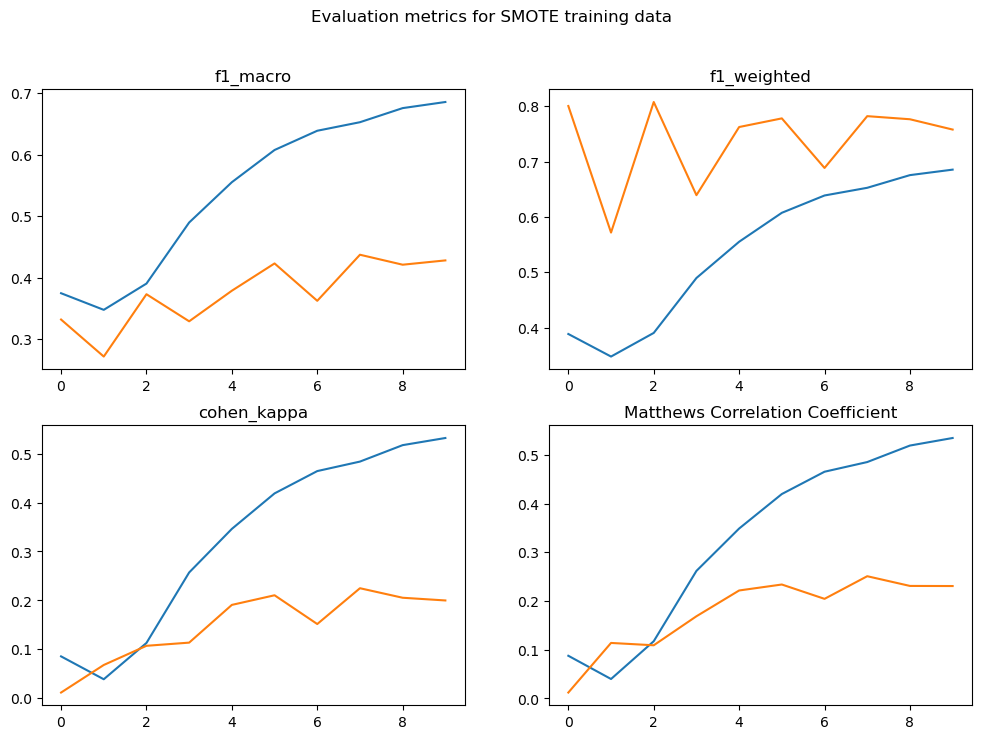

61/61 [==============================] - 0s 2ms/step


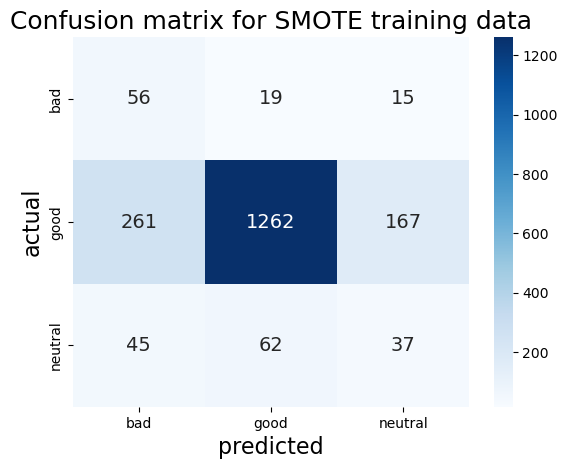

              precision    recall  f1-score   support

           0       0.15      0.62      0.25        90
           1       0.94      0.75      0.83      1690
           2       0.17      0.26      0.20       144

    accuracy                           0.70      1924
   macro avg       0.42      0.54      0.43      1924
weighted avg       0.85      0.70      0.76      1924



In [108]:
buildmodel(X_train_sm, y_train_sm, 
           metrics_title = 'Evaluation metrics for SMOTE training data', 
           con_mat_title = 'Confusion matrix for SMOTE training data')

In [194]:
model = buildmodel(learning_rate = 0.001)

model.fit(X_train_sm, 
          y_train_sm,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          verbose = 1, 
          class_weight = None)

Epoch 1/10
476/476 [==============================] - 8s 14ms/step - loss: 1.0983 - accuracy: 0.3338 - f1_macro: 0.3737 - f1_weighted: 0.3815 - kappa: 0.0954 - MatthewsCorrelationCoefficient: 0.1030 - val_loss: 1.0924 - val_accuracy: 0.8451 - val_f1_macro: 0.3316 - val_f1_weighted: 0.8110 - val_kappa: 0.0168 - val_MatthewsCorrelationCoefficient: 0.0193
Epoch 2/10
476/476 [==============================] - 7s 14ms/step - loss: 1.0925 - accuracy: 0.3527 - f1_macro: 0.2755 - f1_weighted: 0.2755 - kappa: 0.0291 - MatthewsCorrelationCoefficient: 0.0385 - val_loss: 1.0974 - val_accuracy: 0.7760 - val_f1_macro: 0.3270 - val_f1_weighted: 0.7778 - val_kappa: 0.0053 - val_MatthewsCorrelationCoefficient: 0.0053
Epoch 3/10
476/476 [==============================] - 7s 14ms/step - loss: 1.0848 - accuracy: 0.3666 - f1_macro: 0.3047 - f1_weighted: 0.3047 - kappa: 0.0499 - MatthewsCorrelationCoefficient: 0.0634 - val_loss: 1.0236 - val_accuracy: 0.8020 - val_f1_macro: 0.3443 - val_f1_weighted: 0.7930 

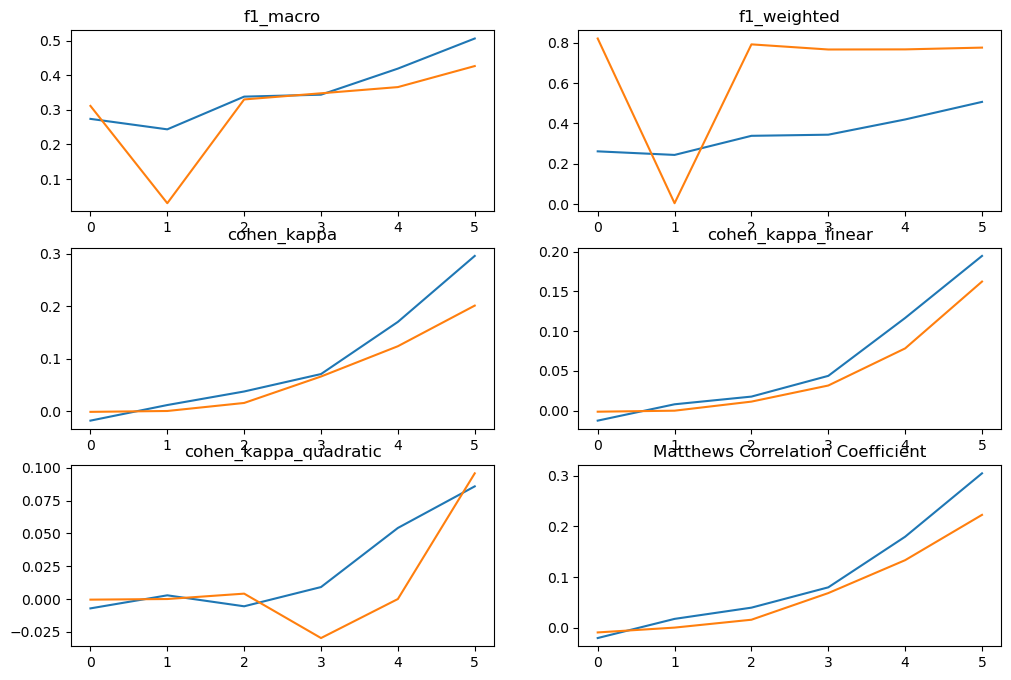

In [147]:
metrics = pd.DataFrame(model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 0s 2ms/step


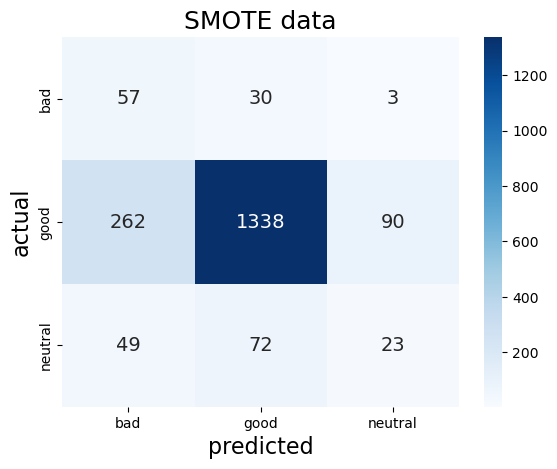

              precision    recall  f1-score   support

           0       0.15      0.63      0.25        90
           1       0.93      0.79      0.85      1690
           2       0.20      0.16      0.18       144

    accuracy                           0.74      1924
   macro avg       0.43      0.53      0.43      1924
weighted avg       0.84      0.74      0.78      1924



In [148]:
y_pred_probs = model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'SMOTE data')

print(classification_report(y_val_labels, y_pred))

Unfortunetaly, this isn't looking to great. Let's now try the most promising training data versions with class_weights, and see if that makes a difference. This means let's check the upsampled training data and the regular one.

**Regular training data with class weights:**

Epoch 1/10
181/181 [==============================] - 5s 20ms/step - loss: 1.1044 - accuracy: 0.4138 - f1_macro: 0.2947 - f1_weighted: 0.6043 - kappa: 0.0262 - MatthewsCorrelationCoefficient: 0.0364 - val_loss: 1.1070 - val_accuracy: 0.0748 - val_f1_macro: 0.0464 - val_f1_weighted: 0.0104 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/10
181/181 [==============================] - 3s 16ms/step - loss: 1.0992 - accuracy: 0.2942 - f1_macro: 0.2172 - f1_weighted: 0.3911 - kappa: 0.0175 - MatthewsCorrelationCoefficient: 0.0330 - val_loss: 1.1133 - val_accuracy: 0.0494 - val_f1_macro: 0.0419 - val_f1_weighted: 0.0097 - val_kappa: 6.6346e-04 - val_MatthewsCorrelationCoefficient: 0.0060
Epoch 3/10
181/181 [==============================] - 3s 16ms/step - loss: 1.0873 - accuracy: 0.4228 - f1_macro: 0.2813 - f1_weighted: 0.5301 - kappa: 0.0353 - MatthewsCorrelationCoefficient: 0.0565 - val_loss: 1.0783 - val_accuracy: 0.5889 - val_f1_macro: 0.3239 - val_f1_weigh

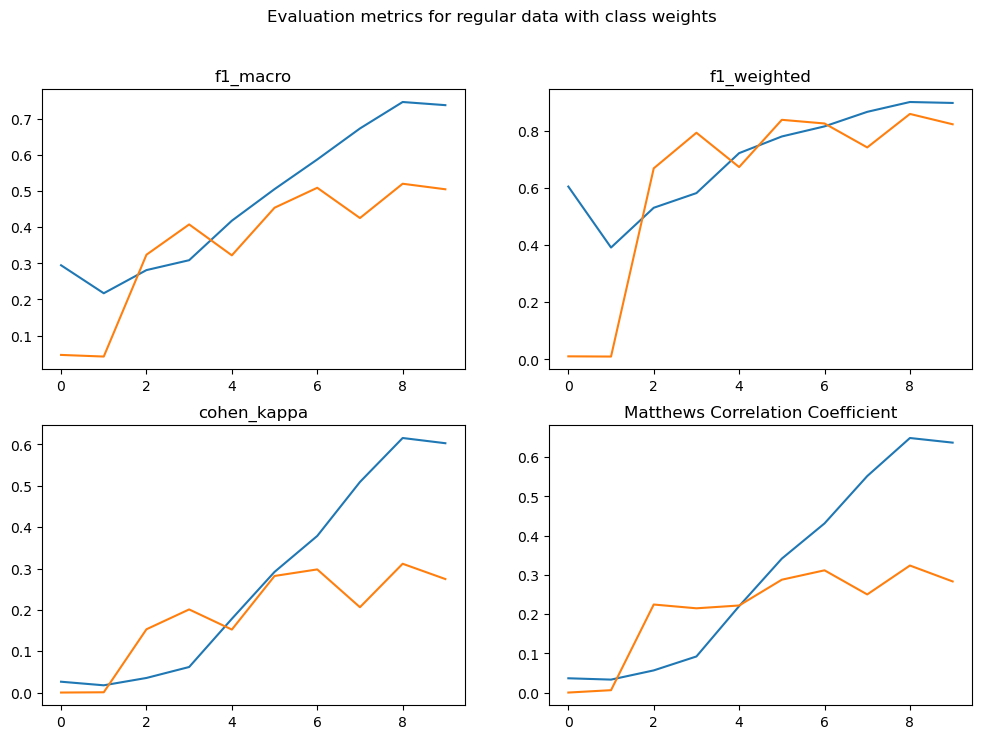

61/61 [==============================] - 0s 2ms/step


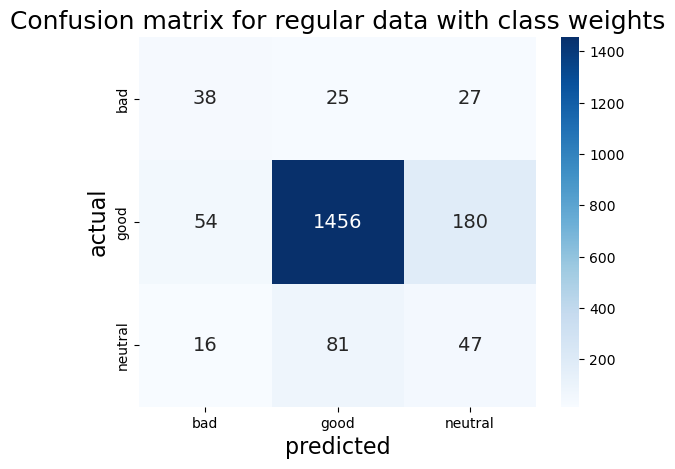

              precision    recall  f1-score   support

           0       0.35      0.42      0.38        90
           1       0.93      0.86      0.90      1690
           2       0.19      0.33      0.24       144

    accuracy                           0.80      1924
   macro avg       0.49      0.54      0.51      1924
weighted avg       0.85      0.80      0.82      1924



In [110]:
buildmodel(padded_train_sequence_not_upsampled, yy_train_not_upsampled, 
           metrics_title = 'Evaluation metrics for regular data with class weights', 
           con_mat_title = 'Confusion matrix for regular data with class weights', 
           class_weight = class_weights)

The model is predicting a lot more of the minority classes here, but getting them wrong and the scores are slightly worse.

**Upsampled training data with class weights:**

Epoch 1/10
476/476 [==============================] - 8s 15ms/step - loss: 2.7124 - accuracy: 0.4198 - f1_macro: 0.3378 - f1_weighted: 0.3243 - kappa: 0.1440 - MatthewsCorrelationCoefficient: 0.1992 - val_loss: 2.6245 - val_accuracy: 0.0816 - val_f1_macro: 0.1089 - val_f1_weighted: 0.0189 - val_kappa: 0.0142 - val_MatthewsCorrelationCoefficient: 0.0473
Epoch 2/10
476/476 [==============================] - 7s 14ms/step - loss: 0.9346 - accuracy: 0.6457 - f1_macro: 0.5229 - f1_weighted: 0.5229 - kappa: 0.4685 - MatthewsCorrelationCoefficient: 0.5490 - val_loss: 2.5246 - val_accuracy: 0.0816 - val_f1_macro: 0.1121 - val_f1_weighted: 0.0194 - val_kappa: 0.0126 - val_MatthewsCorrelationCoefficient: 0.0462
Epoch 3/10
476/476 [==============================] - 7s 14ms/step - loss: 0.5339 - accuracy: 0.6702 - f1_macro: 0.5549 - f1_weighted: 0.5549 - kappa: 0.5052 - MatthewsCorrelationCoefficient: 0.5916 - val_loss: 1.8945 - val_accuracy: 0.1388 - val_f1_macro: 0.1560 - val_f1_weighted: 0.1331 

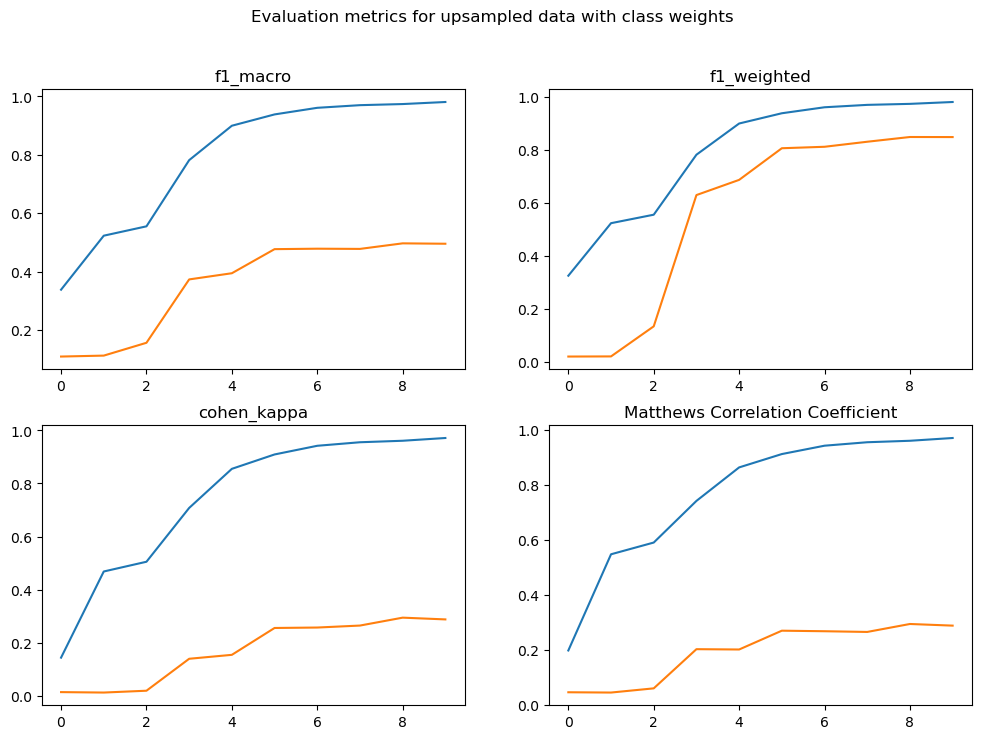

61/61 [==============================] - 0s 2ms/step


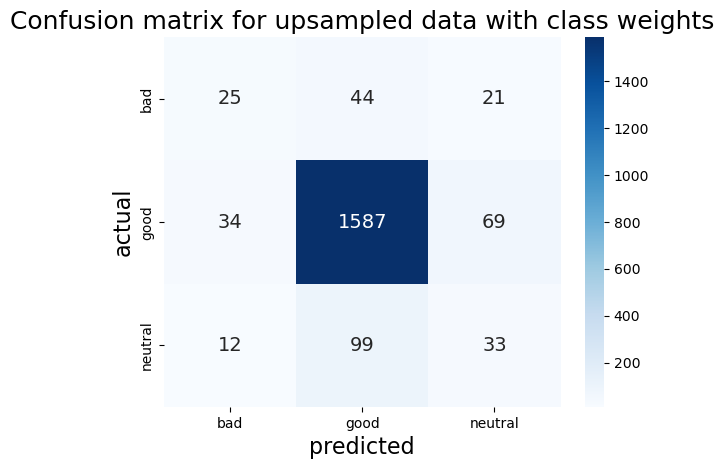

              precision    recall  f1-score   support

           0       0.35      0.28      0.31        90
           1       0.92      0.94      0.93      1690
           2       0.27      0.23      0.25       144

    accuracy                           0.85      1924
   macro avg       0.51      0.48      0.50      1924
weighted avg       0.84      0.85      0.85      1924



In [112]:
buildmodel(padded_train_sequence_upsampled, yy_train_upsampled, 
           metrics_title = 'Evaluation metrics for upsampled data with class weights', 
           con_mat_title = 'Confusion matrix for upsampled data with class weights', 
           class_weight = class_weights)

Similar issue here, so adding class weights doesn't seem to help. Before moving on to grid search to fine tune the final model, let's try the glove word embeddings for the embedding layer, and as usual we will set it to not be trainable. To make things easy here we will just burrow the functions from this link: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html.

In [46]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [47]:
word_index = tokenizer.word_index
EMBEDDING_DIM = 100 #has to be this to work with 'glove.6B.100d.txt', but there are other files to choose from

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [34]:
#the embedding layer is the only thing different here
def build_glove_model(learning_rate = 0.001, dropout = 0.3):
    model= Sequential([
        Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix], input_length=500, trainable=False),
        GlobalAveragePooling1D(),
        Dense(32, activation='relu'),
        Dropout(dropout),
        Dense(3,activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate = learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1_score_macro, f1_score_weighted, kappa, matthew])
    
    return model

Epoch 1/10
181/181 [==============================] - 4s 17ms/step - loss: 0.7602 - accuracy: 0.8609 - f1_macro: 0.3817 - f1_weighted: 0.8012 - kappa: 0.0832 - MatthewsCorrelationCoefficient: 0.0834 - val_loss: 0.5293 - val_accuracy: 0.8784 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8215 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/10
181/181 [==============================] - 2s 13ms/step - loss: 0.5182 - accuracy: 0.8782 - f1_macro: 0.3117 - f1_weighted: 0.8212 - kappa: -1.1921e-07 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4784 - val_accuracy: 0.8784 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8215 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/10
181/181 [==============================] - 2s 13ms/step - loss: 0.4788 - accuracy: 0.8782 - f1_macro: 0.3117 - f1_weighted: 0.8212 - kappa: -1.1921e-07 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4505 - val_accuracy: 0.8784 - val_f1_macro:

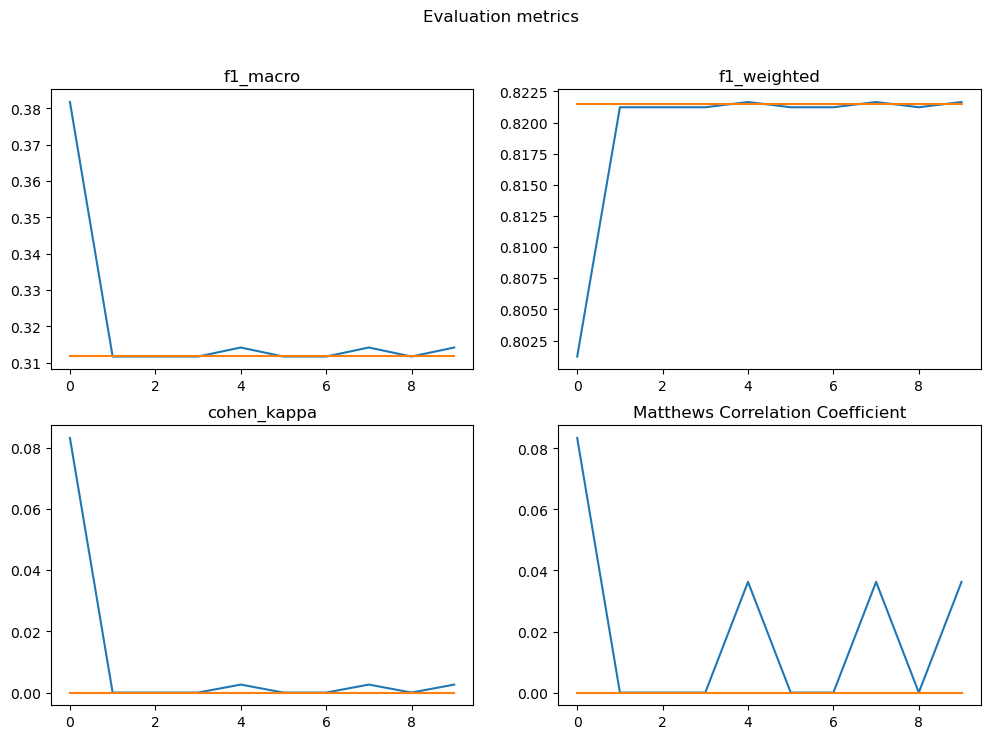

61/61 [==============================] - 0s 3ms/step


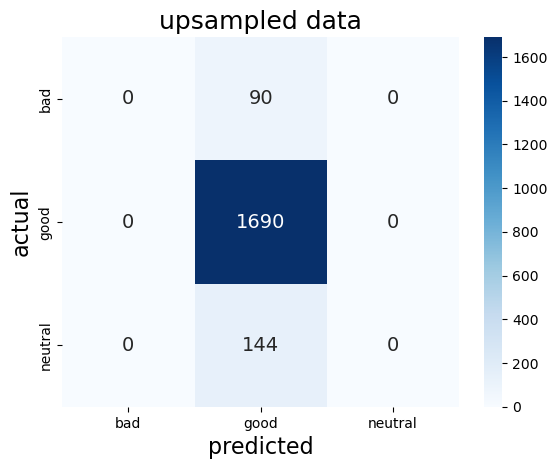

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.88      1.00      0.94      1690
           2       0.00      0.00      0.00       144

    accuracy                           0.88      1924
   macro avg       0.29      0.33      0.31      1924
weighted avg       0.77      0.88      0.82      1924



C:\Users\RaviB\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RaviB\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RaviB\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
glove_model = build_glove_model()

glove_model.fit(padded_train_sequence_not_upsampled, 
          yy_train_not_upsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          class_weight = None)

metrics = pd.DataFrame(glove_model.history.history)

plot_metric_history(metrics)

y_pred_probs = glove_model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'upsampled data')

print(classification_report(y_val_labels, y_pred))

In [123]:
glove_model = build_glove_model()

glove_model.fit(padded_train_sequence_upsampled, 
          yy_train_upsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          class_weight = None)

Epoch 1/10
476/476 [==============================] - 7s 14ms/step - loss: 1.0873 - accuracy: 0.4047 - f1_macro: 0.4470 - f1_weighted: 0.4575 - kappa: 0.1792 - MatthewsCorrelationCoefficient: 0.1792 - val_loss: 1.0585 - val_accuracy: 0.6627 - val_f1_macro: 0.3473 - val_f1_weighted: 0.7175 - val_kappa: 0.0903 - val_MatthewsCorrelationCoefficient: 0.1083
Epoch 2/10
476/476 [==============================] - 5s 11ms/step - loss: 1.0624 - accuracy: 0.4574 - f1_macro: 0.4439 - f1_weighted: 0.4439 - kappa: 0.1862 - MatthewsCorrelationCoefficient: 0.1944 - val_loss: 1.0721 - val_accuracy: 0.6263 - val_f1_macro: 0.3839 - val_f1_weighted: 0.7014 - val_kappa: 0.1398 - val_MatthewsCorrelationCoefficient: 0.1766
Epoch 3/10
476/476 [==============================] - 6s 12ms/step - loss: 1.0346 - accuracy: 0.4878 - f1_macro: 0.4778 - f1_weighted: 0.4778 - kappa: 0.2317 - MatthewsCorrelationCoefficient: 0.2361 - val_loss: 0.9763 - val_accuracy: 0.7027 - val_f1_macro: 0.3972 - val_f1_weighted: 0.7506 

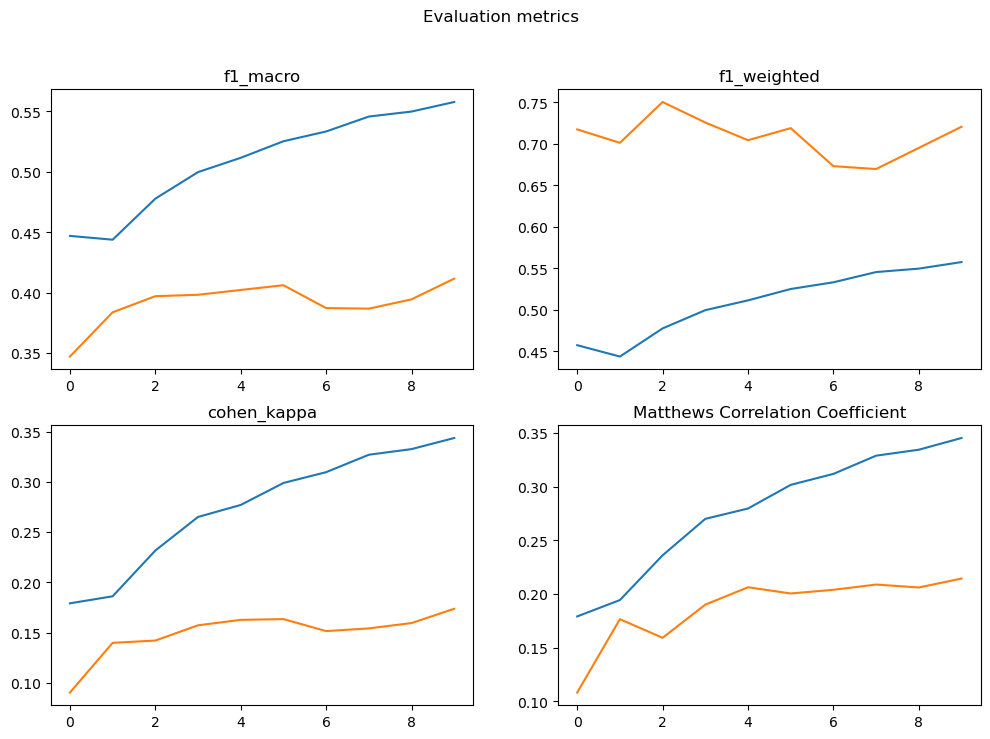

In [124]:
metrics = pd.DataFrame(glove_model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 0s 3ms/step


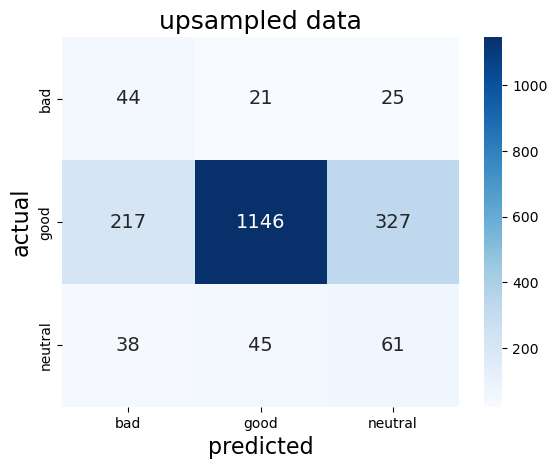

              precision    recall  f1-score   support

           0       0.15      0.49      0.23        90
           1       0.95      0.68      0.79      1690
           2       0.15      0.42      0.22       144

    accuracy                           0.65      1924
   macro avg       0.41      0.53      0.41      1924
weighted avg       0.85      0.65      0.72      1924



In [125]:
y_pred_probs = glove_model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'upsampled data')

print(classification_report(y_val_labels, y_pred))

Neither of these are any good, clearly. 

Now let's start **GridSearch**, and tune for the best model. From the above results, there are two best model contenders, based on the evaluation metrics. The regular non-tampered data, and the upsampled data, both with no class weights or word embeddings. We will use grid search on them both. The evaluation metrics all have similar trends, so it seems like we would use any. The f1_weighted score tends to be high, though,, which might be a bit missleading, and the oposite is true for the kappa and matthew scores. Thus, we will use the f1_macro metric for grid search. The f1 score is also often used in sentiment analysis projects as well, so it might be nice to keep the trend.

In [35]:
#to do grid search with keras, we need to use the KerasClassifier function from scikeras, 
#which means we need to rebuild this function, without the model compilation step, 
#as KerasClassifier will do that for us
def createmodel(dropout = 0.3):
    model = Sequential([
        Embedding(max_vocab, 1000, input_length = 500),
        GlobalAveragePooling1D(),
        Dense(32, activation='relu'),
        Dropout(dropout),
        Dense(3, activation='softmax')
    ])
    
    return model

In [39]:
clf = KerasClassifier(
    model = createmodel,
    loss = "categorical_crossentropy",
    optimizer = "adam",
    optimizer__learning_rate = 0.001,
    model__dropout = 0.3,
    dropout = 0.3,
    verbose = False
)

param_grid = {'epochs': [6, 8, 10], 'batch_size': [32, 128], 'dropout': [0.3, 0.5]}

#cv=3 just to speed up run times
grid = GridSearchCV(estimator = clf, param_grid = param_grid, scoring = 'f1_macro', cv = 3, verbose = True)

#note, verbose is false in the clf, so there won't be any loading bars, but this will take a while.
grid.fit(padded_train_sequence_not_upsampled, y_train_not_upsampled_labels)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=KerasClassifier(dropout=0.3, loss='categorical_crossentropy', model=<function createmodel at 0x0000023CF484EC10>, model__dropout=0.3, optimizer='adam', optimizer__learning_rate=0.001, verbose=False),
             param_grid={'batch_size': [32, 128], 'dropout': [0.3, 0.5],
                         'epochs': [6, 8, 10]},
             scoring='f1_macro', verbose=True)

In [40]:
grid.best_params_

{'batch_size': 32, 'dropout': 0.5, 'epochs': 10}

In [41]:
print('Grid search training f1_macro score:', f1_score(grid.predict(padded_train_sequence), y_train, average = 'macro'))

nn_grid_pred = grid.predict(padded_val_sequence)
grid_search_f1_score = f1_score(nn_grid_pred, y_val_labels, average = 'macro')
print('Grid search validation f1_macro score:', grid_search_f1_score)

Grid search training f1_macro score: 0.7891028386897011
Grid search validation f1_macro score: 0.5509955106070493


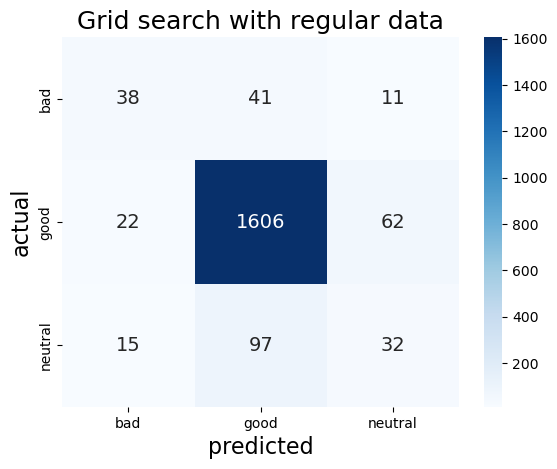

              precision    recall  f1-score   support

           0       0.51      0.42      0.46        90
           1       0.92      0.95      0.94      1690
           2       0.30      0.22      0.26       144

    accuracy                           0.87      1924
   macro avg       0.58      0.53      0.55      1924
weighted avg       0.86      0.87      0.86      1924



In [42]:
plot_con_mat(y_val_labels, nn_grid_pred, 'Grid search with regular data')

print(classification_report(y_val_labels, nn_grid_pred))

So this is definitely one of the better scores, and the confusion matrix looks good too. Let's try this with the upsampled data as well, and finally decide on the best model here.

In [43]:
clf = KerasClassifier(
    model=createmodel,
    loss="categorical_crossentropy",
    optimizer="adam",
    optimizer__learning_rate = 0.001,
    model__dropout = 0.3,
    dropout = 0.3,
    verbose = False
)

param_grid = {'epochs': [6, 8, 10], 'batch_size': [32, 128], 'dropout': [0.3, 0.5]}

#cv=3 just to speed up run times
grid = GridSearchCV(estimator = clf, param_grid = param_grid, scoring = 'f1_macro', cv = 3, verbose = True)

grid.fit(padded_train_sequence_upsampled, y_train_upsampled_labels)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=KerasClassifier(dropout=0.3, loss='categorical_crossentropy', model=<function createmodel at 0x0000023CF484EC10>, model__dropout=0.3, optimizer='adam', optimizer__learning_rate=0.001, verbose=False),
             param_grid={'batch_size': [32, 128], 'dropout': [0.3, 0.5],
                         'epochs': [6, 8, 10]},
             scoring='f1_macro', verbose=True)

In [44]:
grid.best_params_

{'batch_size': 32, 'dropout': 0.5, 'epochs': 10}

In [45]:
print('Grid search training f1_macro score for upsampled data:', 
      f1_score(grid.predict(padded_train_sequence), y_train, average = 'macro'))

nn_grid_pred = grid.predict(padded_val_sequence)
upsampled_grid_search_f1_score = f1_score(nn_grid_pred, y_val_labels, average = 'macro')
print('Grid search validation f1_macro score for upsampled data:', upsampled_grid_search_f1_score)

Grid search training f1_macro score for upsampled data: 0.8856844778799835
Grid search validation f1_macro score for upsampled data: 0.4867458296739375


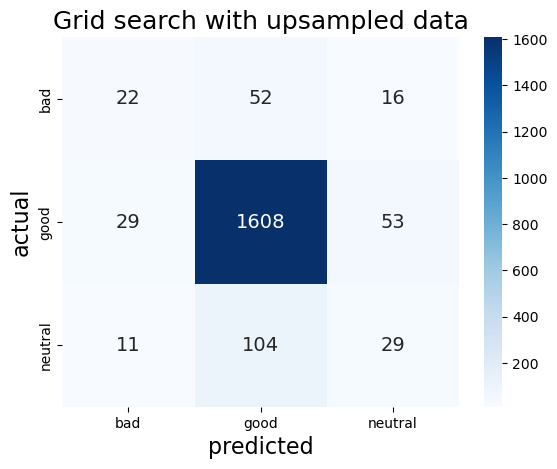

              precision    recall  f1-score   support

           0       0.35      0.24      0.29        90
           1       0.91      0.95      0.93      1690
           2       0.30      0.20      0.24       144

    accuracy                           0.86      1924
   macro avg       0.52      0.47      0.49      1924
weighted avg       0.84      0.86      0.85      1924



In [46]:
plot_con_mat(y_val_labels, nn_grid_pred, 'Grid search with upsampled data')

print(classification_report(y_val_labels, nn_grid_pred))

Well, after doing two long grid searches it seems we have the best model here. We will try the LSTM next and grid search for that too. At the end the best model will be chosen, and then re-trained on all the data.

### LSTM

Now let's try a network with LSTM's.

In [36]:
def buildLSTM(learning_rate = 0.001, dropout = 0.3):
    model = Sequential([
        Embedding(max_vocab, 1000, input_length = 500),
        LSTM(25),
        Dropout(dropout),
        Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate = learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1_score_macro, f1_score_weighted, kappa, matthew])
    
    return model

**LSTM Model with regular training data:**

In [60]:
LSTM_model = buildLSTM(learning_rate = 0.001)

LSTM_model.fit(padded_train_sequence_not_upsampled, 
          yy_train_not_upsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 8, 
          class_weight = None)

Epoch 1/8
181/181 [==============================] - 9s 41ms/step - loss: 0.4533 - accuracy: 0.8756 - f1_macro: 0.3832 - f1_weighted: 0.8327 - kappa: 0.1068 - MatthewsCorrelationCoefficient: 0.1414 - val_loss: 0.3665 - val_accuracy: 0.8784 - val_f1_macro: 0.3585 - val_f1_weighted: 0.8323 - val_kappa: 0.0878 - val_MatthewsCorrelationCoefficient: 0.1471
Epoch 2/8
181/181 [==============================] - 6s 35ms/step - loss: 0.2581 - accuracy: 0.9085 - f1_macro: 0.6236 - f1_weighted: 0.8934 - kappa: 0.4680 - MatthewsCorrelationCoefficient: 0.4995 - val_loss: 0.3862 - val_accuracy: 0.8784 - val_f1_macro: 0.4848 - val_f1_weighted: 0.8552 - val_kappa: 0.2622 - val_MatthewsCorrelationCoefficient: 0.2884
Epoch 3/8
181/181 [==============================] - 6s 36ms/step - loss: 0.1435 - accuracy: 0.9527 - f1_macro: 0.8414 - f1_weighted: 0.9510 - kappa: 0.7743 - MatthewsCorrelationCoefficient: 0.7761 - val_loss: 0.4408 - val_accuracy: 0.8586 - val_f1_macro: 0.5013 - val_f1_weighted: 0.8499 - v

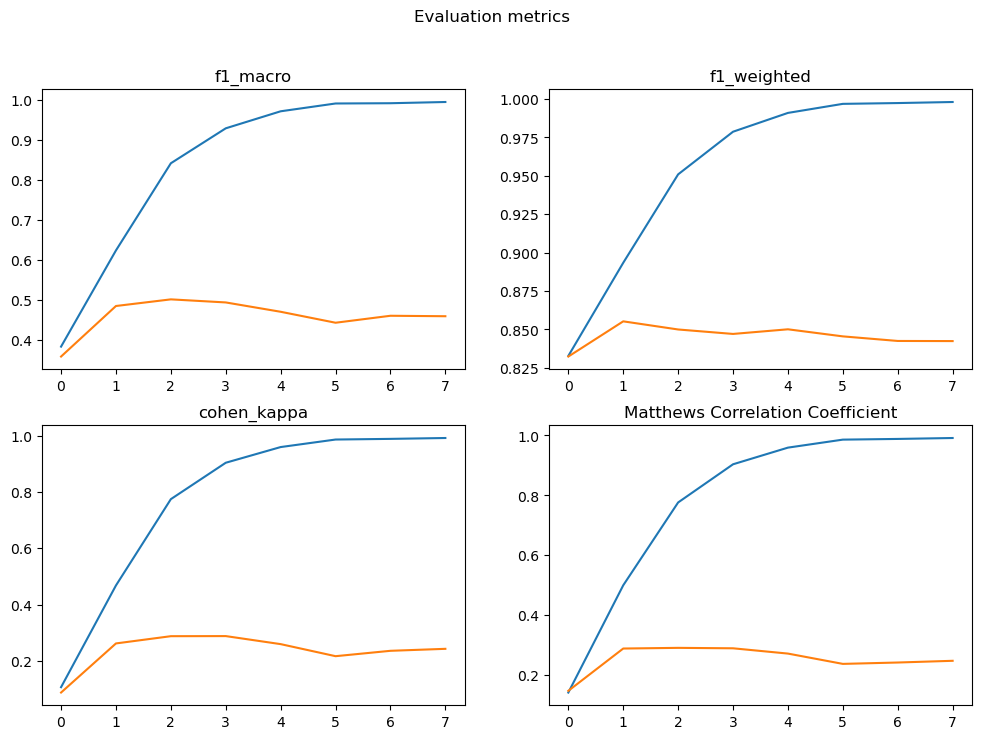

In [61]:
metrics = pd.DataFrame(LSTM_model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 1s 11ms/step


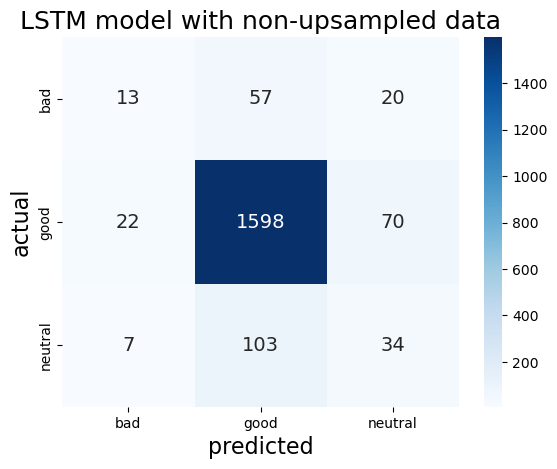

              precision    recall  f1-score   support

           0       0.31      0.14      0.20        90
           1       0.91      0.95      0.93      1690
           2       0.27      0.24      0.25       144

    accuracy                           0.85      1924
   macro avg       0.50      0.44      0.46      1924
weighted avg       0.83      0.85      0.84      1924



In [62]:
y_pred_probs = LSTM_model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'LSTM model with non-upsampled data')

print(classification_report(y_val_labels, y_pred))

**LSTM Model with downsampled training data:**

In [216]:
LSTM_model = buildLSTM(learning_rate = 0.001)

LSTM_model.fit(padded_train_sequence_downsampled, 
          yy_train_downsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          class_weight = None)

Epoch 1/10
26/26 [==============================] - 5s 109ms/step - loss: 1.0675 - accuracy: 0.4790 - f1_macro: 0.5380 - f1_weighted: 0.7281 - kappa: 0.3783 - MatthewsCorrelationCoefficient: 0.3843 - val_loss: 0.9612 - val_accuracy: 0.7032 - val_f1_macro: 0.4212 - val_f1_weighted: 0.7561 - val_kappa: 0.1778 - val_MatthewsCorrelationCoefficient: 0.2025
Epoch 2/10
26/26 [==============================] - 2s 71ms/step - loss: 0.7562 - accuracy: 0.8259 - f1_macro: 0.8229 - f1_weighted: 0.8229 - kappa: 0.7389 - MatthewsCorrelationCoefficient: 0.7485 - val_loss: 0.8346 - val_accuracy: 0.6325 - val_f1_macro: 0.4157 - val_f1_weighted: 0.7069 - val_kappa: 0.1776 - val_MatthewsCorrelationCoefficient: 0.2271
Epoch 3/10
26/26 [==============================] - 2s 71ms/step - loss: 0.2916 - accuracy: 0.9420 - f1_macro: 0.9420 - f1_weighted: 0.9420 - kappa: 0.9130 - MatthewsCorrelationCoefficient: 0.9130 - val_loss: 0.8760 - val_accuracy: 0.6279 - val_f1_macro: 0.4064 - val_f1_weighted: 0.7044 - val

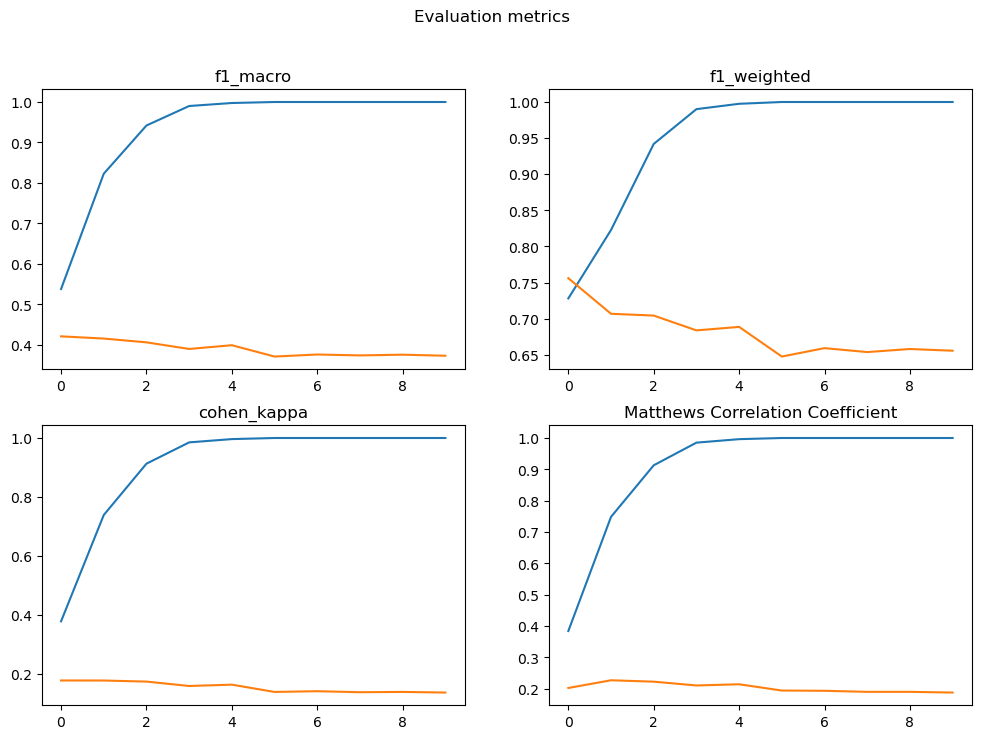

In [217]:
metrics = pd.DataFrame(LSTM_model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 1s 12ms/step


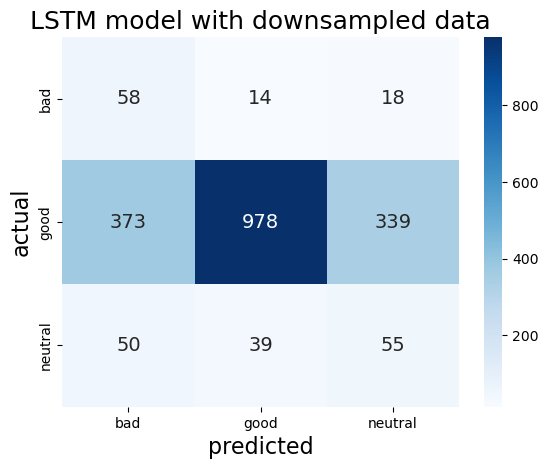

              precision    recall  f1-score   support

           0       0.12      0.64      0.20        90
           1       0.95      0.58      0.72      1690
           2       0.13      0.38      0.20       144

    accuracy                           0.57      1924
   macro avg       0.40      0.54      0.37      1924
weighted avg       0.85      0.57      0.66      1924



In [218]:
y_pred_probs = LSTM_model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'LSTM model with downsampled data')

print(classification_report(y_val_labels, y_pred))

**LSTM Model with upsampled training data:**

In [219]:
LSTM_model = buildLSTM(learning_rate = 0.001)

LSTM_model.fit(padded_train_sequence_upsampled, 
          yy_train_upsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          class_weight = None)

Epoch 1/10
476/476 [==============================] - 18s 34ms/step - loss: 0.2805 - accuracy: 0.8981 - f1_macro: 0.8621 - f1_weighted: 0.8602 - kappa: 0.7911 - MatthewsCorrelationCoefficient: 0.7933 - val_loss: 0.5361 - val_accuracy: 0.8503 - val_f1_macro: 0.4716 - val_f1_weighted: 0.8410 - val_kappa: 0.2446 - val_MatthewsCorrelationCoefficient: 0.2470
Epoch 2/10
476/476 [==============================] - 16s 33ms/step - loss: 0.0410 - accuracy: 0.9892 - f1_macro: 0.9892 - f1_weighted: 0.9892 - kappa: 0.9838 - MatthewsCorrelationCoefficient: 0.9839 - val_loss: 0.6674 - val_accuracy: 0.8597 - val_f1_macro: 0.4860 - val_f1_weighted: 0.8488 - val_kappa: 0.2763 - val_MatthewsCorrelationCoefficient: 0.2803
Epoch 3/10
476/476 [==============================] - 16s 33ms/step - loss: 0.0163 - accuracy: 0.9961 - f1_macro: 0.9961 - f1_weighted: 0.9961 - kappa: 0.9942 - MatthewsCorrelationCoefficient: 0.9942 - val_loss: 0.8987 - val_accuracy: 0.8098 - val_f1_macro: 0.4599 - val_f1_weighted: 0.82

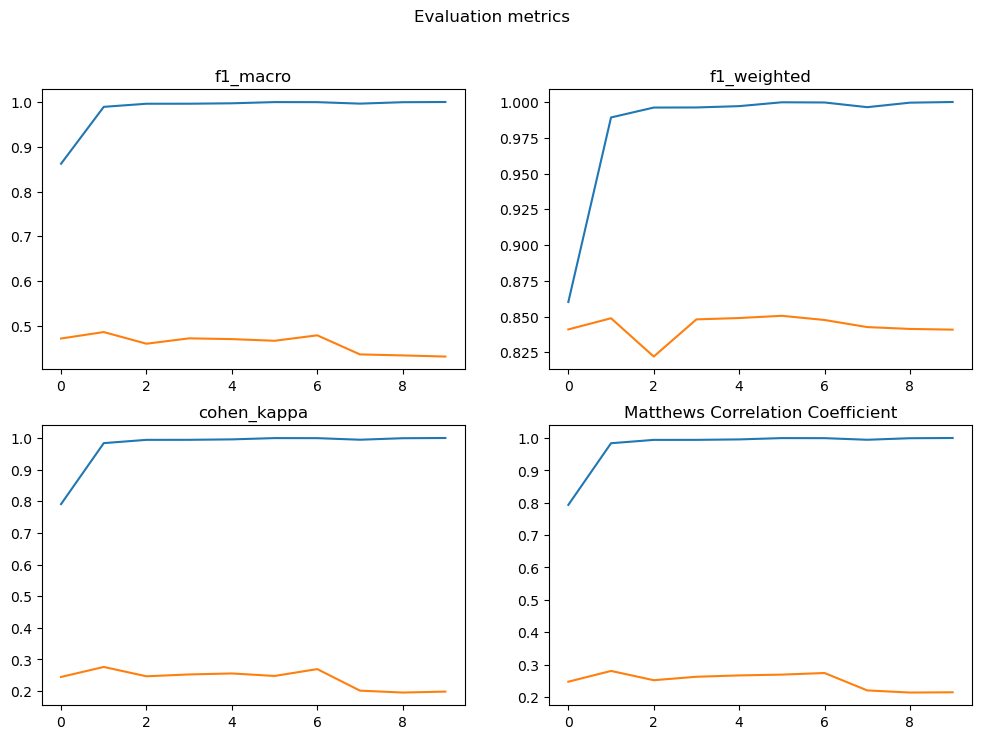

In [220]:
metrics = pd.DataFrame(LSTM_model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 1s 12ms/step


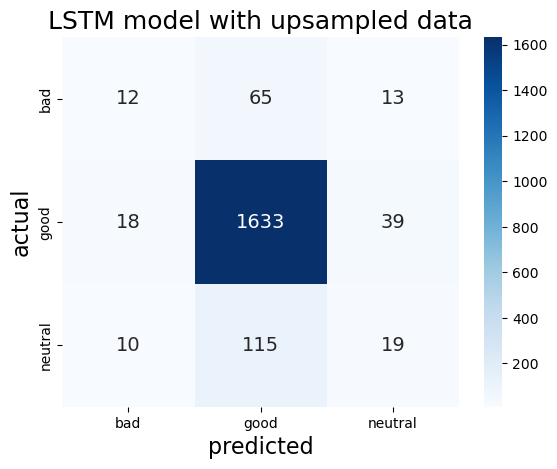

              precision    recall  f1-score   support

           0       0.30      0.13      0.18        90
           1       0.90      0.97      0.93      1690
           2       0.27      0.13      0.18       144

    accuracy                           0.86      1924
   macro avg       0.49      0.41      0.43      1924
weighted avg       0.83      0.86      0.84      1924



In [221]:
y_pred_probs = LSTM_model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'LSTM model with upsampled data')

print(classification_report(y_val_labels, y_pred))

**LSTM Model with SMOTE training data:**

In [225]:
LSTM_model = buildLSTM(learning_rate = 0.001, dropout = 0.3)

LSTM_model.fit(X_train_sm, 
          y_train_sm,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          class_weight = None)

Epoch 1/10
476/476 [==============================] - 19s 34ms/step - loss: 0.8551 - accuracy: 0.5612 - f1_macro: 0.5689 - f1_weighted: 0.5887 - kappa: 0.3828 - MatthewsCorrelationCoefficient: 0.3833 - val_loss: 0.6612 - val_accuracy: 0.7594 - val_f1_macro: 0.4550 - val_f1_weighted: 0.7942 - val_kappa: 0.2268 - val_MatthewsCorrelationCoefficient: 0.2432
Epoch 2/10
476/476 [==============================] - 15s 33ms/step - loss: 0.6699 - accuracy: 0.6728 - f1_macro: 0.6707 - f1_weighted: 0.6707 - kappa: 0.5092 - MatthewsCorrelationCoefficient: 0.5095 - val_loss: 0.7074 - val_accuracy: 0.7328 - val_f1_macro: 0.4332 - val_f1_weighted: 0.7775 - val_kappa: 0.2071 - val_MatthewsCorrelationCoefficient: 0.2284
Epoch 3/10
476/476 [==============================] - 16s 33ms/step - loss: 0.5209 - accuracy: 0.7678 - f1_macro: 0.7670 - f1_weighted: 0.7670 - kappa: 0.6517 - MatthewsCorrelationCoefficient: 0.6518 - val_loss: 0.6709 - val_accuracy: 0.7786 - val_f1_macro: 0.4701 - val_f1_weighted: 0.80

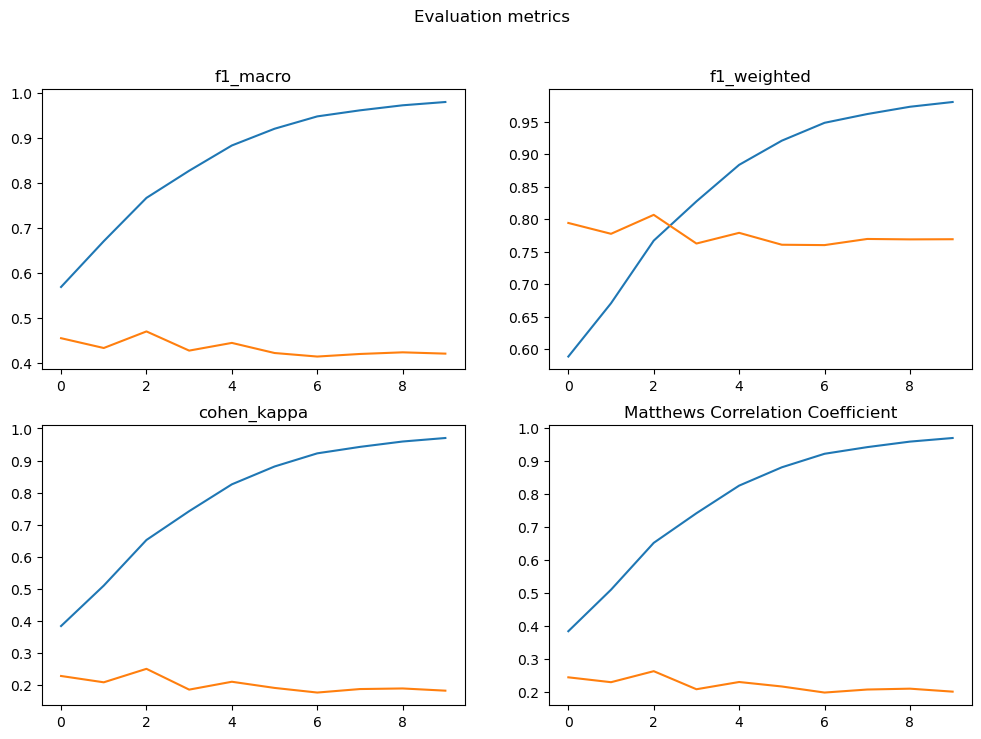

In [226]:
metrics = pd.DataFrame(LSTM_model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 1s 12ms/step


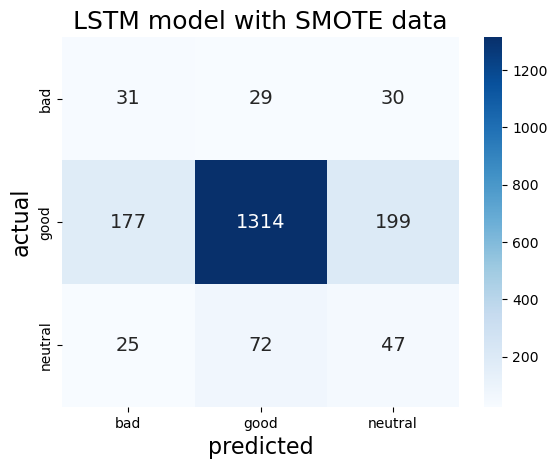

              precision    recall  f1-score   support

           0       0.13      0.34      0.19        90
           1       0.93      0.78      0.85      1690
           2       0.17      0.33      0.22       144

    accuracy                           0.72      1924
   macro avg       0.41      0.48      0.42      1924
weighted avg       0.83      0.72      0.77      1924



In [227]:
y_pred_probs = LSTM_model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'LSTM model with SMOTE data')

print(classification_report(y_val_labels, y_pred))

Again, let's look at the most promising models but with class weights this time, to see if they help.

**LSTM model with regular training data and class weights:**

In [222]:
LSTM_model = buildLSTM(learning_rate = 0.001)

LSTM_model.fit(padded_train_sequence_not_upsampled, 
          yy_train_not_upsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          class_weight = class_weights)

Epoch 1/10
181/181 [==============================] - 10s 42ms/step - loss: 0.9892 - accuracy: 0.7557 - f1_macro: 0.4485 - f1_weighted: 0.8041 - kappa: 0.2077 - MatthewsCorrelationCoefficient: 0.2138 - val_loss: 0.7720 - val_accuracy: 0.6533 - val_f1_macro: 0.4172 - val_f1_weighted: 0.7265 - val_kappa: 0.1973 - val_MatthewsCorrelationCoefficient: 0.2462
Epoch 2/10
181/181 [==============================] - 7s 36ms/step - loss: 0.5160 - accuracy: 0.8359 - f1_macro: 0.6528 - f1_weighted: 0.8611 - kappa: 0.4934 - MatthewsCorrelationCoefficient: 0.5363 - val_loss: 0.6173 - val_accuracy: 0.7302 - val_f1_macro: 0.4518 - val_f1_weighted: 0.7754 - val_kappa: 0.2270 - val_MatthewsCorrelationCoefficient: 0.2566
Epoch 3/10
181/181 [==============================] - 7s 36ms/step - loss: 0.1969 - accuracy: 0.9198 - f1_macro: 0.8242 - f1_weighted: 0.9283 - kappa: 0.7126 - MatthewsCorrelationCoefficient: 0.7381 - val_loss: 0.5792 - val_accuracy: 0.7978 - val_f1_macro: 0.4872 - val_f1_weighted: 0.8194

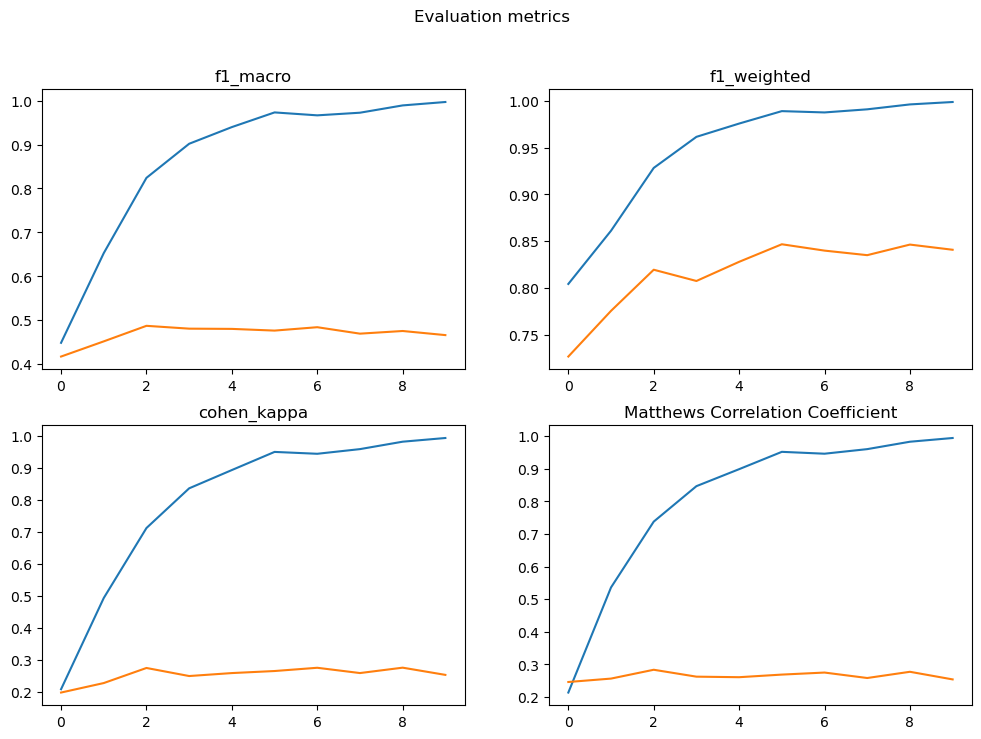

In [223]:
metrics = pd.DataFrame(LSTM_model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 1s 12ms/step


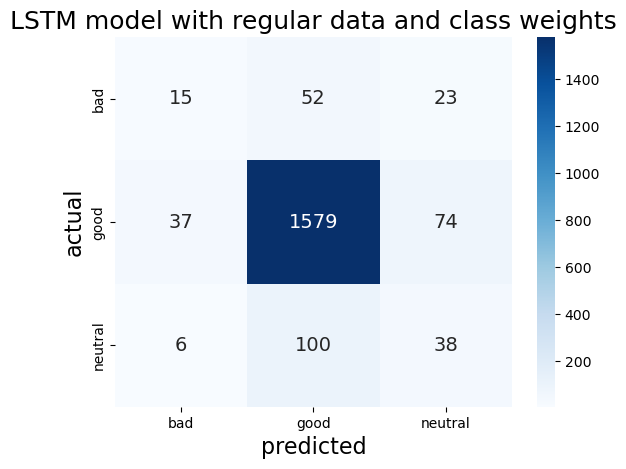

              precision    recall  f1-score   support

           0       0.26      0.17      0.20        90
           1       0.91      0.93      0.92      1690
           2       0.28      0.26      0.27       144

    accuracy                           0.85      1924
   macro avg       0.48      0.45      0.47      1924
weighted avg       0.83      0.85      0.84      1924



In [224]:
y_pred_probs = LSTM_model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'LSTM model with regular data and class weights')

print(classification_report(y_val_labels, y_pred))

**LSTM model with upsampled training data and class weights:**

In [230]:
LSTM_model = buildLSTM(learning_rate = 0.001)

LSTM_model.fit(padded_train_sequence_upsampled, 
          yy_train_upsampled,
          validation_data = (padded_val_sequence, yy_val),
          batch_size = 32,
          epochs = 10, 
          class_weight = class_weights)

Epoch 1/10
476/476 [==============================] - 19s 35ms/step - loss: 0.7131 - accuracy: 0.7836 - f1_macro: 0.7461 - f1_weighted: 0.7360 - kappa: 0.6359 - MatthewsCorrelationCoefficient: 0.6666 - val_loss: 0.8595 - val_accuracy: 0.7531 - val_f1_macro: 0.4523 - val_f1_weighted: 0.7884 - val_kappa: 0.2179 - val_MatthewsCorrelationCoefficient: 0.2362
Epoch 2/10
476/476 [==============================] - 16s 33ms/step - loss: 0.0643 - accuracy: 0.9726 - f1_macro: 0.9724 - f1_weighted: 0.9724 - kappa: 0.9589 - MatthewsCorrelationCoefficient: 0.9597 - val_loss: 0.6753 - val_accuracy: 0.8280 - val_f1_macro: 0.4658 - val_f1_weighted: 0.8308 - val_kappa: 0.2502 - val_MatthewsCorrelationCoefficient: 0.2509
Epoch 3/10
476/476 [==============================] - 16s 33ms/step - loss: 0.0621 - accuracy: 0.9807 - f1_macro: 0.9806 - f1_weighted: 0.9806 - kappa: 0.9710 - MatthewsCorrelationCoefficient: 0.9714 - val_loss: 0.9153 - val_accuracy: 0.7651 - val_f1_macro: 0.4581 - val_f1_weighted: 0.79

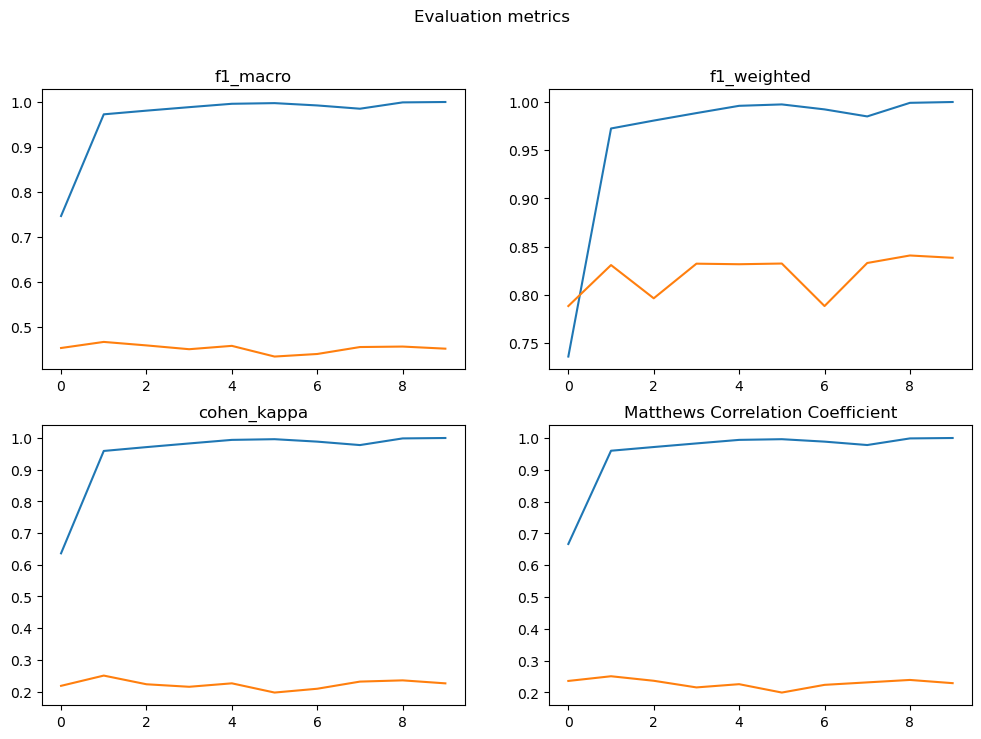

In [231]:
metrics = pd.DataFrame(LSTM_model.history.history)

plot_metric_history(metrics)

61/61 [==============================] - 1s 12ms/step


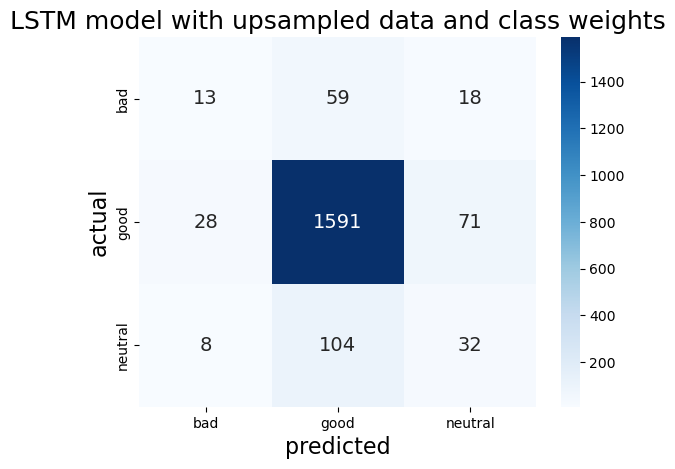

              precision    recall  f1-score   support

           0       0.27      0.14      0.19        90
           1       0.91      0.94      0.92      1690
           2       0.26      0.22      0.24       144

    accuracy                           0.85      1924
   macro avg       0.48      0.44      0.45      1924
weighted avg       0.83      0.85      0.84      1924



In [232]:
y_pred_probs = LSTM_model.predict(padded_val_sequence)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_con_mat(y_val_labels, y_pred, 'LSTM model with upsampled data and class weights')

print(classification_report(y_val_labels, y_pred))

Now let's try glove word embeddings for the LSTM model. Again, just on the regular training data and the upscaled training data, since those are the ones that were the most promising before.

In [40]:
#only difference between this model and the one before is the embedding layer
def buildLSTM_glove(X_train, y_train, 
                    validation_data = (padded_val_sequence, yy_val), 
                    true_y_train_labels = y_train_not_upsampled_labels,
                    true_y_test_labels = y_val_labels, 
                    print_f1_scores = False, 
                    learning_rate = 0.001, 
                    dropout = 0.3, 
                    batch_size = 32, 
                    epochs = 10, 
                    class_weights = None, 
                    metric_plots_title = 'Evaluation metrics', 
                    con_mat_title = 'LSTM model with glove word embeddings'):
    model = Sequential([
        #glove word embedding layer, same as before
        Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix], input_length=500, trainable=False),
        LSTM(25),
        Dropout(dropout),
        Dense(3, activation='softmax')
    ])
    
    #same compiling as usual
    model.compile(optimizer=Adam(learning_rate = learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1_score_macro, f1_score_weighted, kappa, matthew])
    
    #same as usual
    model.fit(X_train, 
              y_train,
              validation_data = validation_data,
              batch_size = 32,
              epochs = epochs, 
              class_weight = class_weights)

    plot_metric_history(pd.DataFrame(model.history.history), suptitle = metric_plots_title)
    
    #validation_data[0] is the test or val X data that we want to predict
    y_pred_probs = model.predict(validation_data[0])
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    #get confusion matrix
    plot_con_mat(true_y_test_labels, y_pred, con_mat_title)
    
    #classification report
    print(classification_report(true_y_test_labels, y_pred))
    
    #printing the final f1 scores if we want to see them explicitely
    if print_f1_scores:
        y_train_pred_probs = model.predict(X_train)
        y_train_pred = np.argmax(y_train_pred_probs, axis=1)
        f1_train_score = f1_score(y_train_pred, true_y_train_labels, average = 'macro')
        f1_test_score = f1_score(y_pred, true_y_test_labels, average = 'macro')
        
        print('f1 training score is:', f1_train_score)
        print('f1 testing score is:', f1_test_score)

First the non-upsampled regular data.

Epoch 1/10
181/181 [==============================] - 8s 32ms/step - loss: 0.4706 - accuracy: 0.8771 - f1_macro: 0.6210 - f1_weighted: 0.7362 - kappa: 0.4569 - MatthewsCorrelationCoefficient: 0.4576 - val_loss: 0.4207 - val_accuracy: 0.8784 - val_f1_macro: 0.3118 - val_f1_weighted: 0.8215 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/10
181/181 [==============================] - 5s 27ms/step - loss: 0.4119 - accuracy: 0.8784 - f1_macro: 0.3133 - f1_weighted: 0.8216 - kappa: 0.0026 - MatthewsCorrelationCoefficient: 0.0357 - val_loss: 0.3966 - val_accuracy: 0.8789 - val_f1_macro: 0.3165 - val_f1_weighted: 0.8230 - val_kappa: 0.0111 - val_MatthewsCorrelationCoefficient: 0.0633
Epoch 3/10
181/181 [==============================] - 5s 27ms/step - loss: 0.3846 - accuracy: 0.8787 - f1_macro: 0.3386 - f1_weighted: 0.8264 - kappa: 0.0379 - MatthewsCorrelationCoefficient: 0.1000 - val_loss: 0.3820 - val_accuracy: 0.8799 - val_f1_macro: 0.3299 - val_f1_weighted:

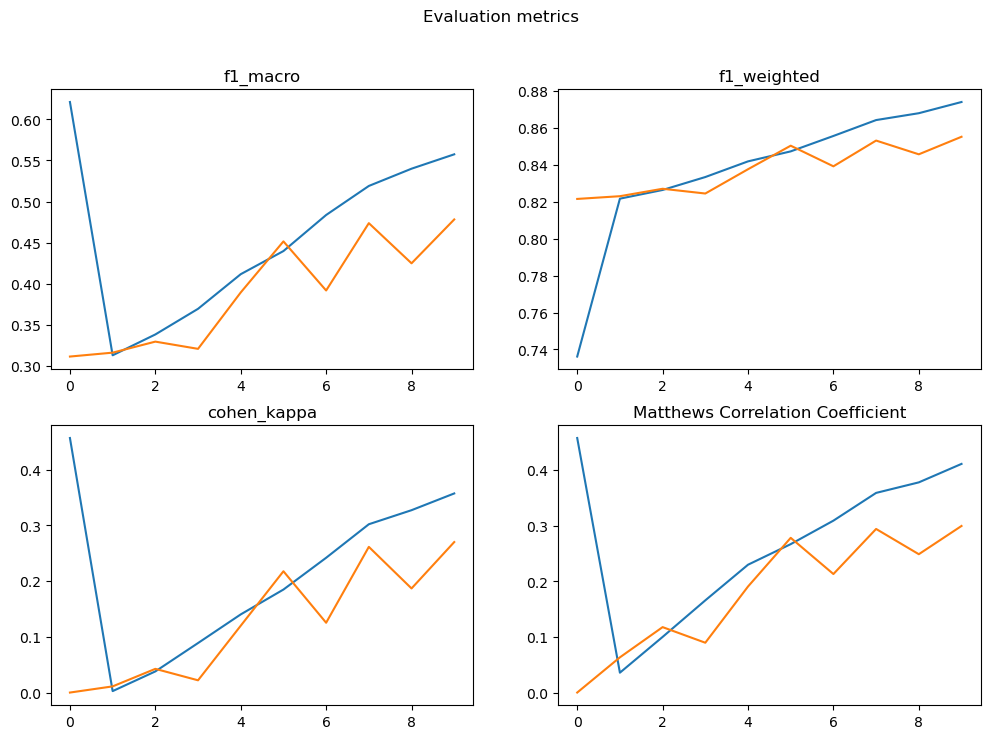

61/61 [==============================] - 1s 9ms/step


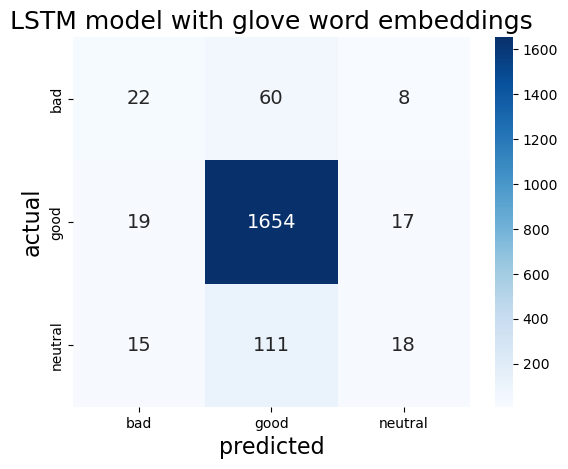

              precision    recall  f1-score   support

           0       0.39      0.24      0.30        90
           1       0.91      0.98      0.94      1690
           2       0.42      0.12      0.19       144

    accuracy                           0.88      1924
   macro avg       0.57      0.45      0.48      1924
weighted avg       0.85      0.88      0.86      1924



In [186]:
buildLSTM_glove(padded_train_sequence_not_upsampled, 
                yy_train_not_upsampled, 
                metric_plots_title = 'Evaluation metrics for glove embedding', 
                con_mat_title = 'LSTM model with glove word embeddings')

Now the upsampled data. And then we will try grid search on the best model here.

Epoch 1/10
476/476 [==============================] - 15s 26ms/step - loss: 0.8689 - accuracy: 0.5860 - f1_macro: 0.6108 - f1_weighted: 0.6227 - kappa: 0.4301 - MatthewsCorrelationCoefficient: 0.4310 - val_loss: 0.9066 - val_accuracy: 0.5489 - val_f1_macro: 0.3875 - val_f1_weighted: 0.6407 - val_kappa: 0.1502 - val_MatthewsCorrelationCoefficient: 0.2182
Epoch 2/10
476/476 [==============================] - 12s 24ms/step - loss: 0.5884 - accuracy: 0.7576 - f1_macro: 0.7564 - f1_weighted: 0.7564 - kappa: 0.6364 - MatthewsCorrelationCoefficient: 0.6369 - val_loss: 0.6167 - val_accuracy: 0.7443 - val_f1_macro: 0.4778 - val_f1_weighted: 0.7890 - val_kappa: 0.2633 - val_MatthewsCorrelationCoefficient: 0.2975
Epoch 3/10
476/476 [==============================] - 12s 24ms/step - loss: 0.4124 - accuracy: 0.8415 - f1_macro: 0.8399 - f1_weighted: 0.8399 - kappa: 0.7622 - MatthewsCorrelationCoefficient: 0.7632 - val_loss: 0.6486 - val_accuracy: 0.7396 - val_f1_macro: 0.4721 - val_f1_weighted: 0.78

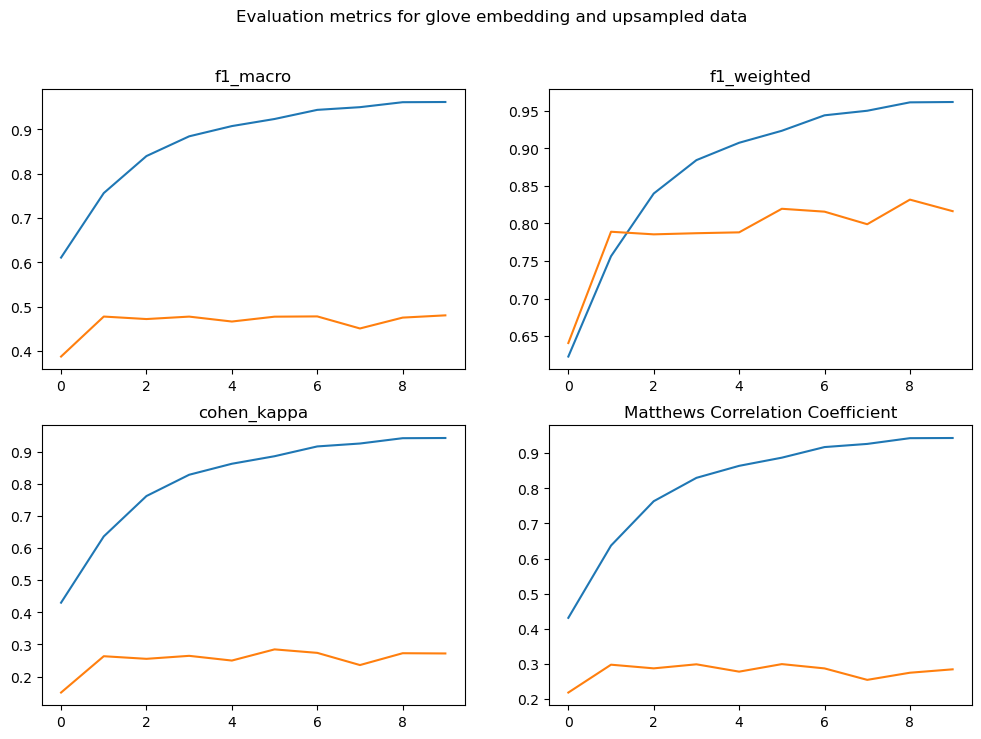

61/61 [==============================] - 1s 8ms/step


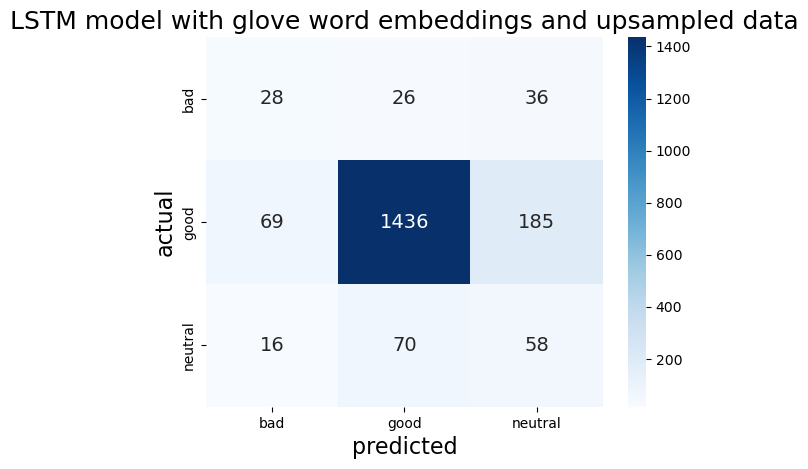

              precision    recall  f1-score   support

           0       0.25      0.31      0.28        90
           1       0.94      0.85      0.89      1690
           2       0.21      0.40      0.27       144

    accuracy                           0.79      1924
   macro avg       0.46      0.52      0.48      1924
weighted avg       0.85      0.79      0.82      1924



In [131]:
buildLSTM_glove(padded_train_sequence_upsampled, 
                yy_train_upsampled, 
                metric_plots_title = 'Evaluation metrics for glove embedding and upsampled data', 
                con_mat_title = 'LSTM model with glove word embeddings and upsampled data')

It looks like the glove embedding layer with or without upsampled data gave the LSTM model the same performace, looking at the f1_macro score here. 

Now let's do **grid search** for the best LSTM model, which in this case was both the non-upsampled and upsampled training data with no weights and glove embedding.

In [48]:
#we have to create this function without compiling the model for the keras classifier to work
def createLSTM(learning_rate = 0.001, dropout = 0.3):
    model = Sequential([
        #note this is the glove embedding layer
        Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix], input_length=500, trainable=False),
        LSTM(25),
        Dropout(dropout),
        Dense(3, activation='softmax')
    ])
    
    return model

 We will start first with non upsampled data.

In [132]:
clf = KerasClassifier(
    model=createLSTM,
    loss="categorical_crossentropy",
    optimizer="adam",
    optimizer__learning_rate = 0.001,
    model__dropout = 0.3,
    dropout = 0.3,
    verbose = False
)

param_grid = {'epochs': [6, 8, 10], 'batch_size': [32, 128], 'dropout': [0.3, 0.5]}

#cv=3 just to speed up run times
LSTM_grid = GridSearchCV(estimator = clf, param_grid = param_grid, scoring = 'f1_macro', cv = 3, verbose = True)

#note, verbose is false in the clf, so there won't be any loading bars, but this will take a while.
LSTM_grid.fit(padded_train_sequence_not_upsampled, y_train_not_upsampled_labels)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=KerasClassifier(dropout=0.3, loss='categorical_crossentropy', model=<function createLSTM at 0x0000023CF68C9A60>, model__dropout=0.3, optimizer='adam', optimizer__learning_rate=0.001, verbose=False),
             param_grid={'batch_size': [32, 128], 'dropout': [0.3, 0.5],
                         'epochs': [6, 8, 10]},
             scoring='f1_macro', verbose=True)

In [133]:
LSTM_grid.best_params_

{'batch_size': 32, 'dropout': 0.3, 'epochs': 10}

In [137]:
print('Grid search training f1_macro score for regular data with LSTM and glove embeddings:', 
      f1_score(LSTM_grid.predict(padded_train_sequence_not_upsampled), y_train_not_upsampled_labels, average = 'macro'))

LSTM_grid_pred = LSTM_grid.predict(padded_val_sequence)
LSTM_upsampled_grid_search_f1_score = f1_score(LSTM_grid_pred, y_val_labels, average = 'macro')
print('Grid search validation f1_macro score for regular data with LSTM and glove embeddings:', 
      LSTM_upsampled_grid_search_f1_score)

Grid search training f1_macro score for regular data with LSTM and glove embeddings: 0.5652708227199381
Grid search validation f1_macro score for regular data with LSTM and glove embeddings: 0.4392514952375815


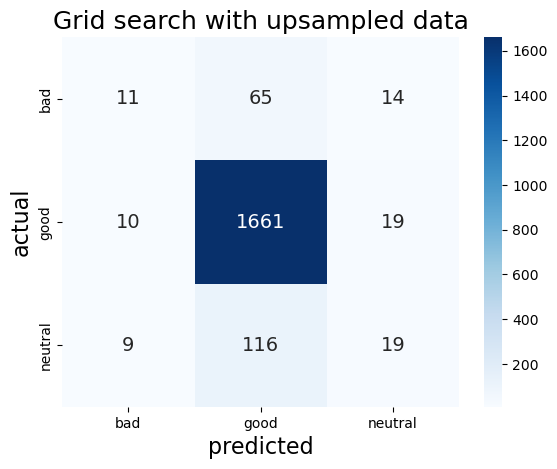

              precision    recall  f1-score   support

           0       0.35      0.24      0.29        90
           1       0.91      0.95      0.93      1690
           2       0.30      0.20      0.24       144

    accuracy                           0.86      1924
   macro avg       0.52      0.47      0.49      1924
weighted avg       0.84      0.86      0.85      1924



In [136]:
plot_con_mat(y_val_labels, LSTM_grid_pred, 'Grid search with regular data')

print(classification_report(y_val_labels, nn_grid_pred))

Now let's look at the upsampled data.

In [49]:
clf = KerasClassifier(
    model=createLSTM,
    loss="categorical_crossentropy",
    optimizer="adam",
    optimizer__learning_rate = 0.001,
    model__dropout = 0.3,
    dropout = 0.3,
    verbose = False
)

param_grid = {'epochs': [6, 8, 10], 'batch_size': [32, 128], 'dropout': [0.3, 0.5]}

#cv=3 just to speed up run times
LSTM_grid = GridSearchCV(estimator = clf, param_grid = param_grid, scoring = 'f1_macro', cv = 3, verbose = True)

#note, verbose is false in the clf, so there won't be any loading bars, but this will take a while.
LSTM_grid.fit(padded_train_sequence_upsampled, y_train_upsampled_labels)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=KerasClassifier(dropout=0.3, loss='categorical_crossentropy', model=<function createLSTM at 0x0000023CF68C9A60>, model__dropout=0.3, optimizer='adam', optimizer__learning_rate=0.001, verbose=False),
             param_grid={'batch_size': [32, 128], 'dropout': [0.3, 0.5],
                         'epochs': [6, 8, 10]},
             scoring='f1_macro', verbose=True)

In [50]:
LSTM_grid.best_params_

{'batch_size': 32, 'dropout': 0.3, 'epochs': 10}

In [51]:
print('Grid search training f1_macro score for upsampled data with LSTM and glove embeddings:', 
      f1_score(LSTM_grid.predict(padded_train_sequence), y_train, average = 'macro'))

LSTM_grid_pred = LSTM_grid.predict(padded_val_sequence)
LSTM_upsampled_grid_search_f1_score = f1_score(LSTM_grid_pred, y_val_labels, average = 'macro')
print('Grid search validation f1_macro score for upsampled data with LSTM and glove embeddings:', 
      LSTM_upsampled_grid_search_f1_score)

Grid search training f1_macro score for upsampled data with LSTM and glove embeddings: 0.8207211842877018
Grid search validation f1_macro score for upsampled data with LSTM and glove embeddings: 0.47891269901426803


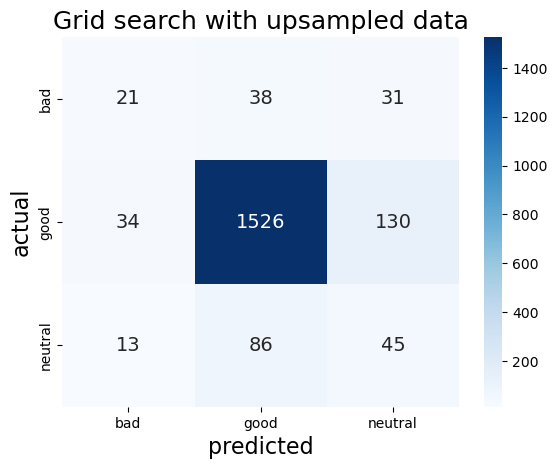

              precision    recall  f1-score   support

           0       0.35      0.24      0.29        90
           1       0.91      0.95      0.93      1690
           2       0.30      0.20      0.24       144

    accuracy                           0.86      1924
   macro avg       0.52      0.47      0.49      1924
weighted avg       0.84      0.86      0.85      1924



In [52]:
plot_con_mat(y_val_labels, LSTM_grid_pred, 'Grid search with upsampled data')

print(classification_report(y_val_labels, nn_grid_pred))

So here we can see the best LSTM model with grid search doesn't help increase the f1_macro score. While it might be a bit dissappointing after trying all these oversampling techniques and other ones, it seems the best performance we can get is twith the original data and the some different hyperparameters.

## Reviewing the best models

That being said, to finish this notebook, let's take these three best models and their optimal hyperparameters and retrain them on the whole training data, with the actual testing set defined at the beginning.

In [58]:
#putting the training and validation data back together to get the original full training data
X_train_full = np.concatenate((padded_train_sequence_not_upsampled, padded_val_sequence))
y_train_full = np.concatenate((yy_train_not_upsampled, yy_val))

#we have to do this for the upsampling data also
X_train_full_upsampled = np.concatenate((padded_train_sequence_upsampled, padded_val_sequence))
y_train_full_upsampled = np.concatenate((yy_train_upsampled, yy_val))

#we need the actual labels, not one hot encoded, for confusion matrix and classification reports
y_train_full_labels = np.argmax(y_train_full, axis = 1)
y_train_full_upsampled_labels = np.argmax(y_train_full_upsampled, axis = 1)

Epoch 1/10
241/241 [==============================] - 5s 18ms/step - loss: 0.5228 - accuracy: 0.8724 - f1_macro: 0.3907 - f1_weighted: 0.8359 - kappa: 0.1117 - MatthewsCorrelationCoefficient: 0.1596 - val_loss: 0.4344 - val_accuracy: 0.8823 - val_f1_macro: 0.3125 - val_f1_weighted: 0.8271 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/10
241/241 [==============================] - 4s 15ms/step - loss: 0.4735 - accuracy: 0.8782 - f1_macro: 0.3117 - f1_weighted: 0.8213 - kappa: 0.0000e+00 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4217 - val_accuracy: 0.8823 - val_f1_macro: 0.3125 - val_f1_weighted: 0.8271 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/10
241/241 [==============================] - 4s 15ms/step - loss: 0.4393 - accuracy: 0.8782 - f1_macro: 0.3117 - f1_weighted: 0.8214 - kappa: 8.8662e-04 - MatthewsCorrelationCoefficient: 0.0143 - val_loss: 0.3800 - val_accuracy: 0.8823 - val_f1_macro: 0.312

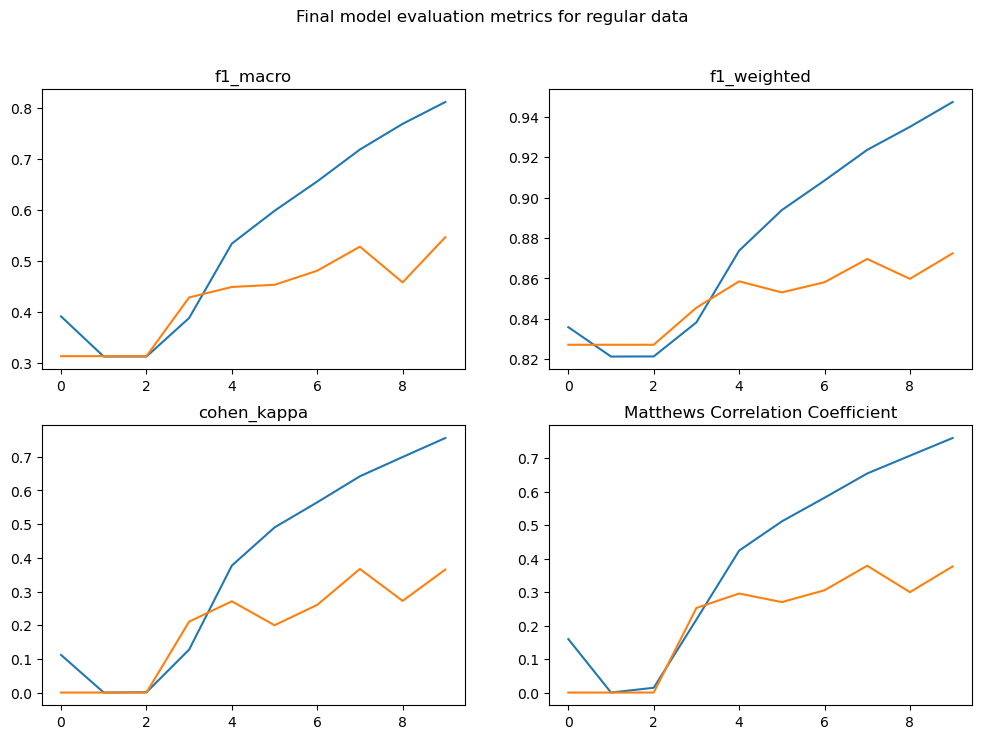

81/81 [==============================] - 0s 2ms/step


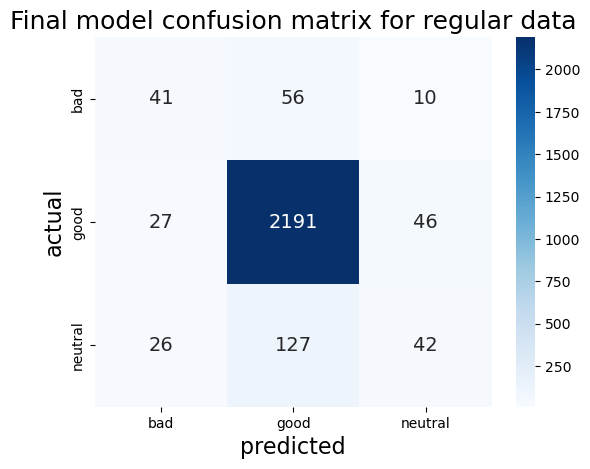

              precision    recall  f1-score   support

           0       0.44      0.38      0.41       107
           1       0.92      0.97      0.94      2264
           2       0.43      0.22      0.29       195

    accuracy                           0.89      2566
   macro avg       0.60      0.52      0.55      2566
weighted avg       0.87      0.89      0.87      2566

241/241 [==============================] - 0s 2ms/step
f1 training score is: 0.8982816701591433
f1 testing score is: 0.5464844711797695


In [57]:
#final model results for the orginal data
buildmodel(X_train_full, y_train_full, 
           validation_data = (padded_test_sequence, yy_test), 
           true_y_train_labels = y_train_full_labels, 
           true_y_test_labels = y_test, 
           print_f1_scores = True, 
           dropout = 0.5, 
           metrics_title = 'Final model evaluation metrics for regular data', 
           con_mat_title = 'Final model confusion matrix for regular data')

Epoch 1/10
536/536 [==============================] - 9s 15ms/step - loss: 0.9951 - accuracy: 0.4833 - f1_macro: 0.4170 - f1_weighted: 0.4627 - kappa: 0.1977 - MatthewsCorrelationCoefficient: 0.2498 - val_loss: 0.7264 - val_accuracy: 0.7354 - val_f1_macro: 0.4952 - val_f1_weighted: 0.7868 - val_kappa: 0.2676 - val_MatthewsCorrelationCoefficient: 0.3092
Epoch 2/10
536/536 [==============================] - 7s 14ms/step - loss: 0.4288 - accuracy: 0.8434 - f1_macro: 0.8405 - f1_weighted: 0.8405 - kappa: 0.7618 - MatthewsCorrelationCoefficient: 0.7645 - val_loss: 0.4365 - val_accuracy: 0.8441 - val_f1_macro: 0.5745 - val_f1_weighted: 0.8582 - val_kappa: 0.3819 - val_MatthewsCorrelationCoefficient: 0.3906
Epoch 3/10
536/536 [==============================] - 7s 14ms/step - loss: 0.2164 - accuracy: 0.9393 - f1_macro: 0.9403 - f1_weighted: 0.9393 - kappa: 0.9082 - MatthewsCorrelationCoefficient: 0.9082 - val_loss: 0.4638 - val_accuracy: 0.8628 - val_f1_macro: 0.5741 - val_f1_weighted: 0.8669 

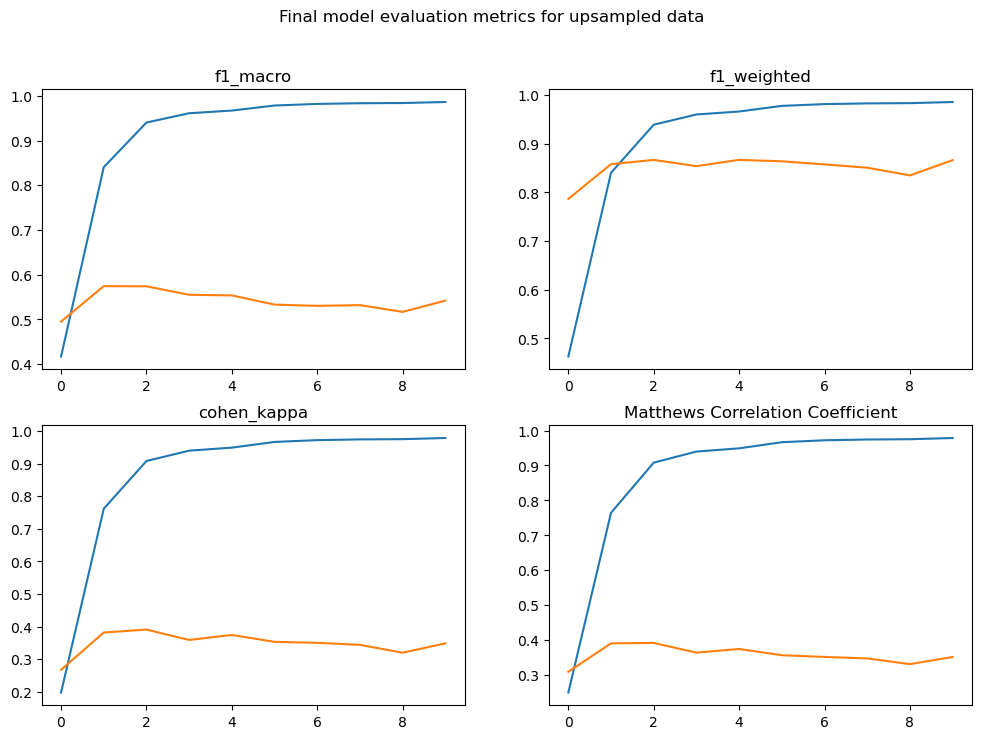

81/81 [==============================] - 0s 2ms/step


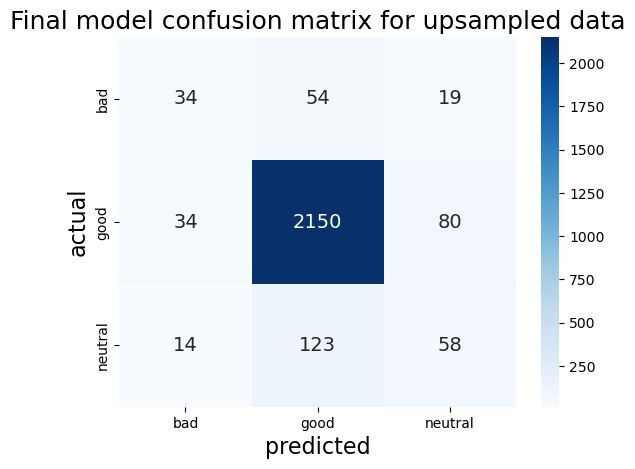

              precision    recall  f1-score   support

           0       0.41      0.32      0.36       107
           1       0.92      0.95      0.94      2264
           2       0.37      0.30      0.33       195

    accuracy                           0.87      2566
   macro avg       0.57      0.52      0.54      2566
weighted avg       0.86      0.87      0.87      2566

536/536 [==============================] - 1s 2ms/step
f1 training score is: 0.9957149298123428
f1 testing score is: 0.5419829769553868


In [59]:
#final model results for neural network model with upsampled data
buildmodel(X_train_full_upsampled, y_train_full_upsampled, 
           validation_data = (padded_test_sequence, yy_test), 
           true_y_train_labels = y_train_full_upsampled_labels, 
           true_y_test_labels = y_test, 
           print_f1_scores = True, 
           dropout = 0.5, 
           metrics_title = 'Final model evaluation metrics for upsampled data', 
           con_mat_title = 'Final model confusion matrix for upsampled data')

Epoch 1/10
241/241 [==============================] - 10s 32ms/step - loss: 0.4736 - accuracy: 0.8656 - f1_macro: 0.3892 - f1_weighted: 0.8324 - kappa: 0.1077 - MatthewsCorrelationCoefficient: 0.1328 - val_loss: 0.4034 - val_accuracy: 0.8823 - val_f1_macro: 0.3125 - val_f1_weighted: 0.8271 - val_kappa: 0.0000e+00 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/10
241/241 [==============================] - 7s 27ms/step - loss: 0.4025 - accuracy: 0.8785 - f1_macro: 0.3225 - f1_weighted: 0.8234 - kappa: 0.0158 - MatthewsCorrelationCoefficient: 0.0646 - val_loss: 0.3822 - val_accuracy: 0.8835 - val_f1_macro: 0.3375 - val_f1_weighted: 0.8316 - val_kappa: 0.0311 - val_MatthewsCorrelationCoefficient: 0.1024
Epoch 3/10
241/241 [==============================] - 7s 27ms/step - loss: 0.3772 - accuracy: 0.8814 - f1_macro: 0.3696 - f1_weighted: 0.8337 - kappa: 0.0892 - MatthewsCorrelationCoefficient: 0.1722 - val_loss: 0.3678 - val_accuracy: 0.8827 - val_f1_macro: 0.3839 - val_f1_weighted

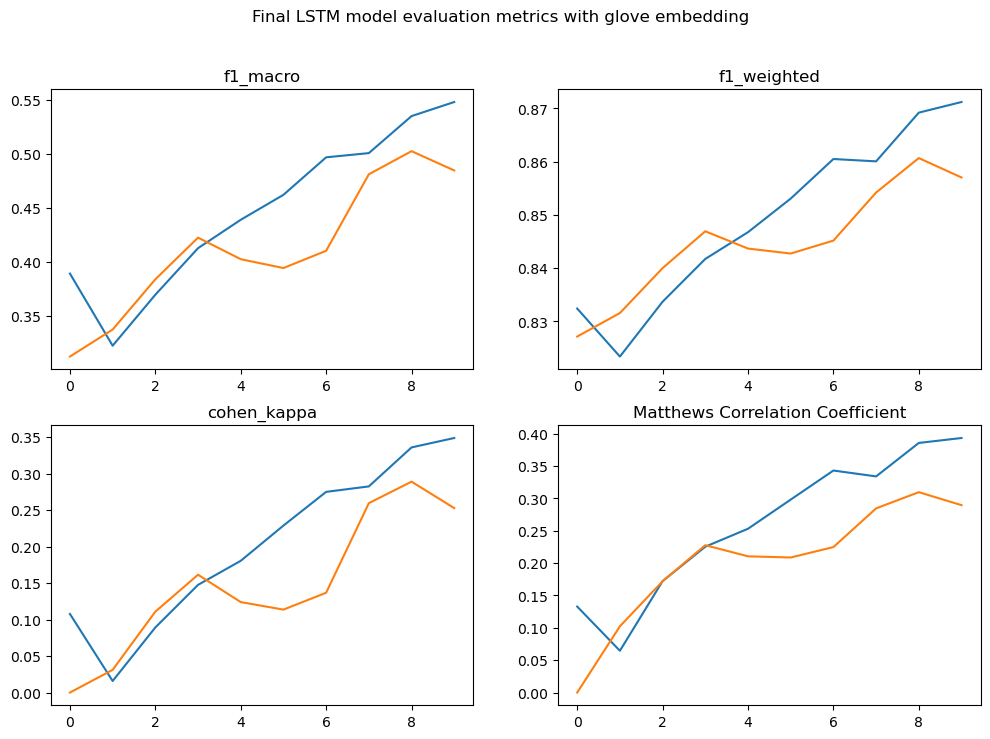

81/81 [==============================] - 1s 8ms/step


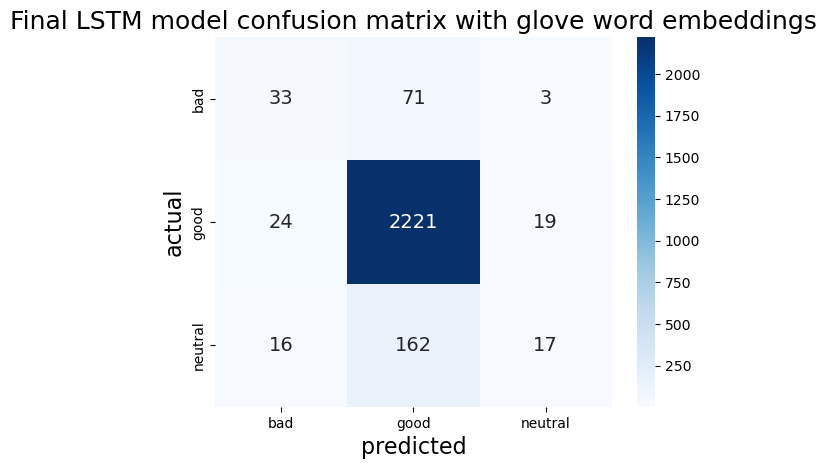

              precision    recall  f1-score   support

           0       0.45      0.31      0.37       107
           1       0.91      0.98      0.94      2264
           2       0.44      0.09      0.15       195

    accuracy                           0.89      2566
   macro avg       0.60      0.46      0.48      2566
weighted avg       0.85      0.89      0.86      2566

241/241 [==============================] - 2s 8ms/step
f1 training score is: 0.5771377100579372
f1 testing score is: 0.48448881594282184


In [60]:
#optimal hyperparameter values from grid search were the default values, so no need to input them here
buildLSTM_glove(X_train_full, 
                y_train_full, 
                true_y_train_labels = y_train_full_labels,
                true_y_test_labels = y_test, 
                print_f1_scores = True,
                validation_data = (padded_test_sequence, yy_test), 
                metric_plots_title = 'Final LSTM model evaluation metrics with glove embedding', 
                con_mat_title = 'Final LSTM model confusion matrix with glove word embeddings'
               )

Epoch 1/10
536/536 [==============================] - 16s 27ms/step - loss: 0.8766 - accuracy: 0.5864 - f1_macro: 0.5927 - f1_weighted: 0.6181 - kappa: 0.4067 - MatthewsCorrelationCoefficient: 0.4089 - val_loss: 0.5400 - val_accuracy: 0.7759 - val_f1_macro: 0.4794 - val_f1_weighted: 0.8085 - val_kappa: 0.2572 - val_MatthewsCorrelationCoefficient: 0.2760
Epoch 2/10
536/536 [==============================] - 13s 25ms/step - loss: 0.5900 - accuracy: 0.7589 - f1_macro: 0.7560 - f1_weighted: 0.7573 - kappa: 0.6354 - MatthewsCorrelationCoefficient: 0.6359 - val_loss: 0.5971 - val_accuracy: 0.7311 - val_f1_macro: 0.4454 - val_f1_weighted: 0.7813 - val_kappa: 0.2269 - val_MatthewsCorrelationCoefficient: 0.2569
Epoch 3/10
536/536 [==============================] - 13s 25ms/step - loss: 0.4063 - accuracy: 0.8508 - f1_macro: 0.8522 - f1_weighted: 0.8501 - kappa: 0.7750 - MatthewsCorrelationCoefficient: 0.7755 - val_loss: 0.7240 - val_accuracy: 0.6933 - val_f1_macro: 0.4359 - val_f1_weighted: 0.75

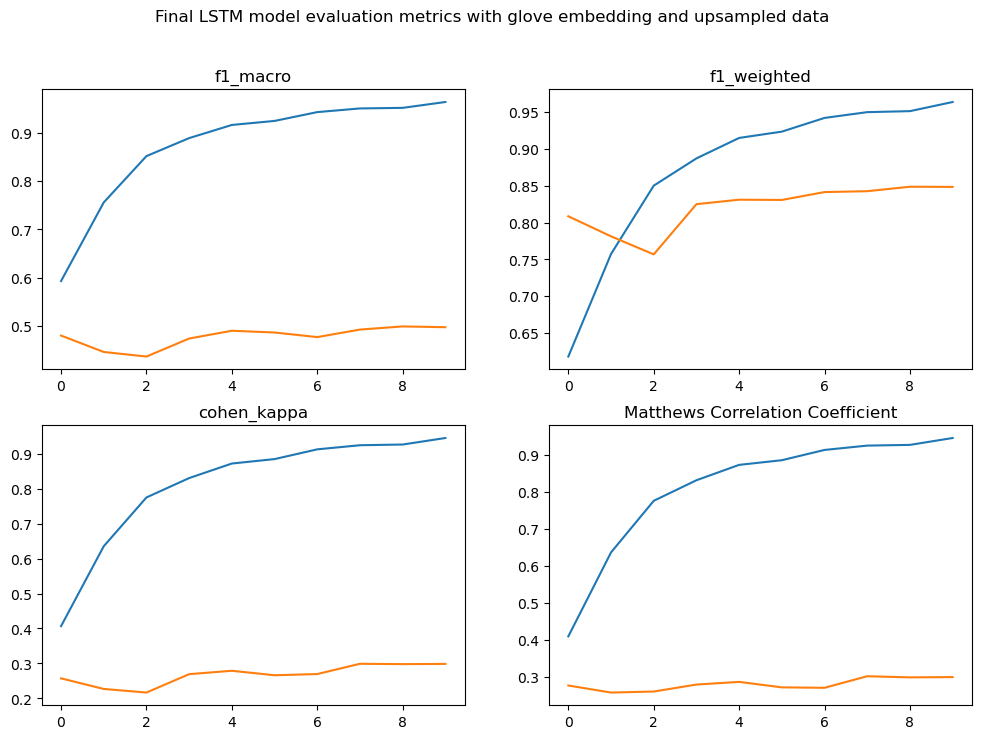

81/81 [==============================] - 1s 8ms/step


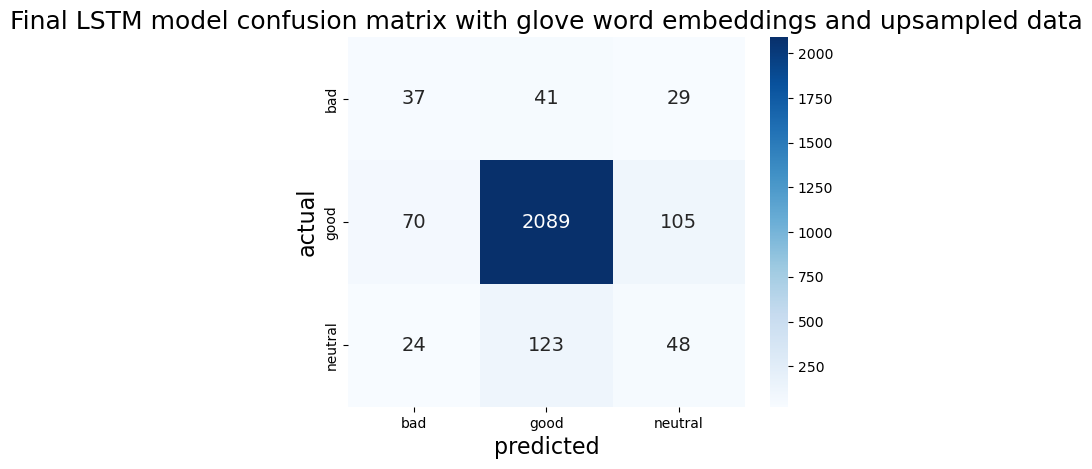

              precision    recall  f1-score   support

           0       0.28      0.35      0.31       107
           1       0.93      0.92      0.92      2264
           2       0.26      0.25      0.25       195

    accuracy                           0.85      2566
   macro avg       0.49      0.50      0.50      2566
weighted avg       0.85      0.85      0.85      2566

536/536 [==============================] - 4s 8ms/step
f1 training score is: 0.9755401522029578
f1 testing score is: 0.49683882258007234


In [61]:
#optimal hyperparameter values from grid search were the default values, so no need to input them here
buildLSTM_glove(X_train_full_upsampled, 
                y_train_full_upsampled, 
                true_y_train_labels = y_train_full_upsampled_labels,
                true_y_test_labels = y_test, 
                print_f1_scores = True,
                validation_data = (padded_test_sequence, yy_test), 
                metric_plots_title = 'Final LSTM model evaluation metrics with glove embedding and upsampled data', 
                con_mat_title = 'Final LSTM model confusion matrix with glove word embeddings and upsampled data'
               )

Now let's compile all these scores and metrics into a table.

In [62]:
#gathered from classification report
f1_macro_training_scores = [0.90, 0.99, 0.58, 0.98]
f1_macro_scores = [0.55, 0.54, 0.48, 0.50]

#manually inputting parameters and aspects of each model
NN_parameters1 = {'epochs': 10, 'dropout': 0.5, 'batch_size': 32, 
                 'glove_embedding': False, 'data_augmentation': None,
                   'optimizer': 'Adam', 'learning_rate': 0.001, 'loss': 'categorical_crossentropy'}

NN_parameters2 = {'epochs': 10, 'dropout': 0.5, 'batch_size': 32, 
                 'glove_embedding': False, 'data_augmentation': 'upsampled',
                   'optimizer': 'Adam', 'learning_rate': 0.001, 'loss': 'categorical_crossentropy'}

LSTM_parameters1 = {'epochs': 10, 'dropout': 0.3, 'batch_size': 32, 
                   'glove_embedding': True, 'data_augmentation': 'upsampled',
                   'optimizer': 'Adam', 'learning_rate': 0.001, 'loss': 'categorical_crossentropy'}

LSTM_parameters2 = {'epochs': 10, 'dropout': 0.3, 'batch_size': 32, 
                   'glove_embedding': True, 'data_augmentation': None,
                   'optimizer': 'Adam', 'learning_rate': 0.001, 'loss': 'categorical_crossentropy'}

#the metrics
params_list = [NN_parameters1, NN_parameters2, LSTM_parameters1, LSTM_parameters2]

metrics_df = pd.DataFrame({'parameters': params_list,
                           'f1_macro training scores': f1_macro_training_scores, 
                           'f1_macro scores': f1_macro_scores})

metrics_df = metrics_df.rename(index={0:'Neural Network', 1:'Neural Network (upsampled)', 
                                      2:'LSTM', 3: 'LSTM (upsampled)'})

pd.set_option('display.max_colwidth', None)

metrics_df

,parameters,f1_macro training scores,f1_macro scores
Neural Network,"{'epochs': 10, 'dropout': 0.5, 'batch_size': 32, 'glove_embedding': False, 'data_augmentation': None, 'optimizer': 'Adam', 'learning_rate': 0.001, 'loss': 'categorical_crossentropy'}",0.90,0.55
Neural Network (upsampled),"{'epochs': 10, 'dropout': 0.5, 'batch_size': 32, 'glove_embedding': False, 'data_augmentation': 'upsampled', 'optimizer': 'Adam', 'learning_rate': 0.001, 'loss': 'categorical_crossentropy'}",0.99,0.54
LSTM,"{'epochs': 10, 'dropout': 0.3, 'batch_size': 32, 'glove_embedding': True, 'data_augmentation': 'upsampled', 'optimizer': 'Adam', 'learning_rate': 0.001, 'loss': 'categorical_crossentropy'}",0.58,0.48
LSTM (upsampled),"{'epochs': 10, 'dropout': 0.3, 'batch_size': 32, 'glove_embedding': True, 'data_augmentation': None, 'optimizer': 'Adam', 'learning_rate': 0.001, 'loss': 'categorical_crossentropy'}",0.98,0.50


For some reason the LSTM model with the original data and glove embeddings has the lowest score but also the lowest training score as well, indicating less overfitting. Perhaps there is something here, and maybe this model is actually the best, provided we improve it with more adjustements that is. Below are the model summaries, just for ease of viewing.

In [155]:
NN_final_model = Sequential([
        Embedding(max_vocab, 1000, input_length=500),
        GlobalAveragePooling1D(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(3,activation='softmax')
    ])

NN_final_model.summary()

Model: "sequential_179"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_181 (Embedding)   (None, 500, 1000)         5000000   
                                                                 
 global_average_pooling1d_98  (None, 1000)             0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_277 (Dense)           (None, 32)                32032     
                                                                 
 dropout_179 (Dropout)       (None, 32)                0         
                                                                 
 dense_278 (Dense)           (None, 3)                 99        
                                                                 
Total params: 5,032,131
Trainable params: 5,032,131
Non-trainable params: 0
__________________________________________

In [150]:
LSTM_final_model = Sequential([
        Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix], input_length=500, trainable=False),
        LSTM(25),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

LSTM_final_model.summary()

Model: "sequential_178"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_179 (Embedding)   (None, 500, 100)          2084700   
                                                                 
 lstm_82 (LSTM)              (None, 25)                12600     
                                                                 
 dropout_178 (Dropout)       (None, 25)                0         
                                                                 
 dense_275 (Dense)           (None, 3)                 78        
                                                                 
Total params: 2,097,378
Trainable params: 12,678
Non-trainable params: 2,084,700
_________________________________________________________________


Let's now show an example of the best model in action, which would be the neural network model with the original training data.

In [65]:
#here is the best model again
NN_final_model = Sequential([
        Embedding(max_vocab, 1000, input_length=500),
        GlobalAveragePooling1D(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(3,activation='softmax')
    ])
    
NN_final_model.compile(optimizer=Adam(learning_rate = 0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1_score_macro])

NN_final_model.fit(X_train_full, y_train_full, validation_data = (padded_test_sequence, yy_test),
              batch_size = 32,
              epochs = 10, 
              verbose = 1, 
              class_weight = None)

Epoch 1/10
241/241 [==============================] - 3s 10ms/step - loss: 0.5211 - accuracy: 0.8776 - f1_macro: 0.3860 - val_loss: 0.4347 - val_accuracy: 0.8823 - val_f1_macro: 0.3125
Epoch 2/10
241/241 [==============================] - 2s 9ms/step - loss: 0.4803 - accuracy: 0.8782 - f1_macro: 0.3117 - val_loss: 0.4250 - val_accuracy: 0.8823 - val_f1_macro: 0.3125
Epoch 3/10
241/241 [==============================] - 2s 9ms/step - loss: 0.4587 - accuracy: 0.8781 - f1_macro: 0.3117 - val_loss: 0.4039 - val_accuracy: 0.8811 - val_f1_macro: 0.3189
Epoch 4/10
241/241 [==============================] - 2s 9ms/step - loss: 0.4016 - accuracy: 0.8808 - f1_macro: 0.3583 - val_loss: 0.3469 - val_accuracy: 0.8815 - val_f1_macro: 0.3630
Epoch 5/10
241/241 [==============================] - 2s 9ms/step - loss: 0.3225 - accuracy: 0.8951 - f1_macro: 0.4931 - val_loss: 0.3303 - val_accuracy: 0.8780 - val_f1_macro: 0.3859
Epoch 6/10
241/241 [==============================] - 2s 9ms/step - loss: 0.278

Now we need to get the original dataset again, so we can use the testing set index to find a product that is in the testing set multiple times. Then we can look at various sentiments for that product.

In [75]:
#we need the full dataset
orig_df = pd.read_json('../data/Musical_Instruments_5.json', lines=True)

In [81]:
testing_data_full = orig_df.iloc[list(X_test.index)]

In [83]:
testing_data_full['asin'].value_counts()

B0002E1G5C    41
B003VWJ2K8    40
B0002F7K7Y    34
B003VWKPHC    26
B0002H0A3S    24
              ..
B002024UDE     1
B00B5OY8EE     1
B007IE5QP0     1
B005E0CPNG     1
B005SUS1JO     1
Name: asin, Length: 802, dtype: int64

So now we can see the some products that show up in the test set many times, based on their product ID occurences. We will look at the product B0002H0A3S.

In [92]:
#get the indices of this product in the test set.
product_example_indices = testing_data_full[testing_data_full['asin'] == 'B0002H0A3S'].index

In [126]:
#now use the indices to get the test set cleaned text column
product_example_test_set = X_test[product_example_indices]

#pre-process this data like before to predict it using the model
product_example_test_set_tokens = tokenizer.texts_to_sequences(product_example_test_set)
product_example_test_set_padded = pad_sequences(product_example_test_set_tokens, maxlen=500)

In [129]:
#getting model predictions
product_example_pred = NN_final_model.predict(product_example_test_set_padded)

#turning predictions into classes
product_example_pred = np.argmax(product_example_pred, axis = 1)

1/1 [==============================] - 0s 18ms/step


Now we have the predicted product reviews, we just need the actual ones for comparison.

In [164]:
#mapping dict to turn ratings into sentiments
sent_dct = {1: 'bad', 2: 'bad', 3: 'neutral', 4: 'good', 5: 'good'}

#getting actual sentiments for the product in question
true_sent_product_example = orig_df.iloc[product_example_indices]['overall'].apply(lambda x: sent_dct[x])

In [177]:
product_example_pred_sent = []
for i in product_example_pred:
    if i == 1:
        product_example_pred_sent.append('good')
    elif i == 0:
        product_example_pred_sent.append('bad')
    else:
        product_example_pred_sent.append('neutral')

In [180]:
product_example_sentiments = pd.Series(product_example_pred_sent, index = product_example_indices)

In [207]:
product_comparison_dict = {'product ID': true_sent_product_example.index, 
                           'predicted sentiments': product_example_sentiments.values, 
                           'true sentiments': true_sent_product_example.values}

pd.DataFrame(product_comparison_dict)

,product ID,predicted sentiments,true sentiments
0,2902,good,good
1,2843,good,good
2,2869,good,good
3,2846,good,good
4,2840,good,good
5,2872,good,good
6,2824,good,good
7,2887,good,good
8,2862,good,good
9,2878,good,good


And there we have it, a table showing the difference in what the model predicted and what the actual values are. As you can see, not too bad, but there are still some errors, and not to surprising that they are regarding the minority classes.